In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from astropy.io import fits

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Define general paths 

In [5]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


Define also the spectral types 

In [7]:
spectral_types = ['O','B','A','F','G','K','M']

# Select a spectral atlas 

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [8]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [9]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

File Type      Teff     Name
0      pickles_uk_1.fits  O5V  39810.70  unknown
1      pickles_uk_2.fits  O9V  35481.40  unknown
2      pickles_uk_3.fits  B0V  28183.80  unknown
3      pickles_uk_4.fits  B1V  22387.20  unknown
4      pickles_uk_5.fits  B3V  19054.60  unknown
..                   ...  ...       ...      ...
126  pickles_uk_127.fits  G8I   4591.98  unknown
127  pickles_uk_128.fits  K2I   4255.98  unknown
128  pickles_uk_129.fits  K3I       NaN  unknown
129  pickles_uk_130.fits  K4I   3990.25  unknown
130  pickles_uk_131.fits  M2I   3451.44  unknown

[131 rows x 4 columns]

# Load with pysynphot the spectra from the selected atlas 

In [10]:
sed_list = np.array(atlas_seds['File'])

In [11]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

Check the spectra were correctly loaded 

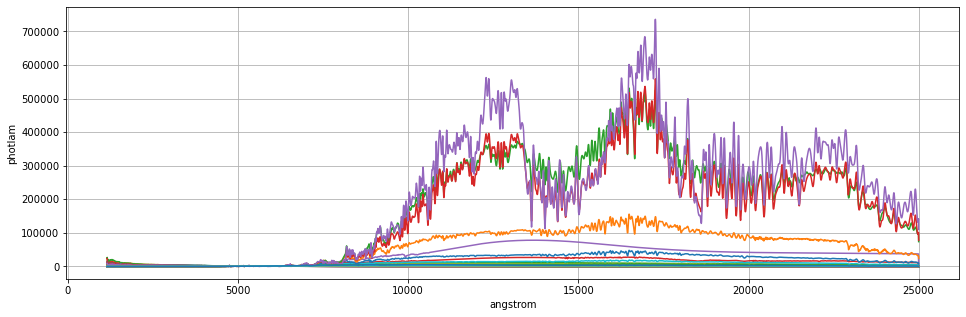

In [12]:
fig=plt.figure(figsize=(16,5))
for sed_ in sed_dict.keys():
    spec = sed_dict[sed_]
    spec.convert('photlam')
    plt.plot(spec.wave,spec.flux)
    plt.xlabel(spec.waveunits)
    plt.ylabel(spec.fluxunits)
    #plt.xlim((0,10000))
    plt.grid()


Let's organise spectra by spectral type 

In [13]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [14]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

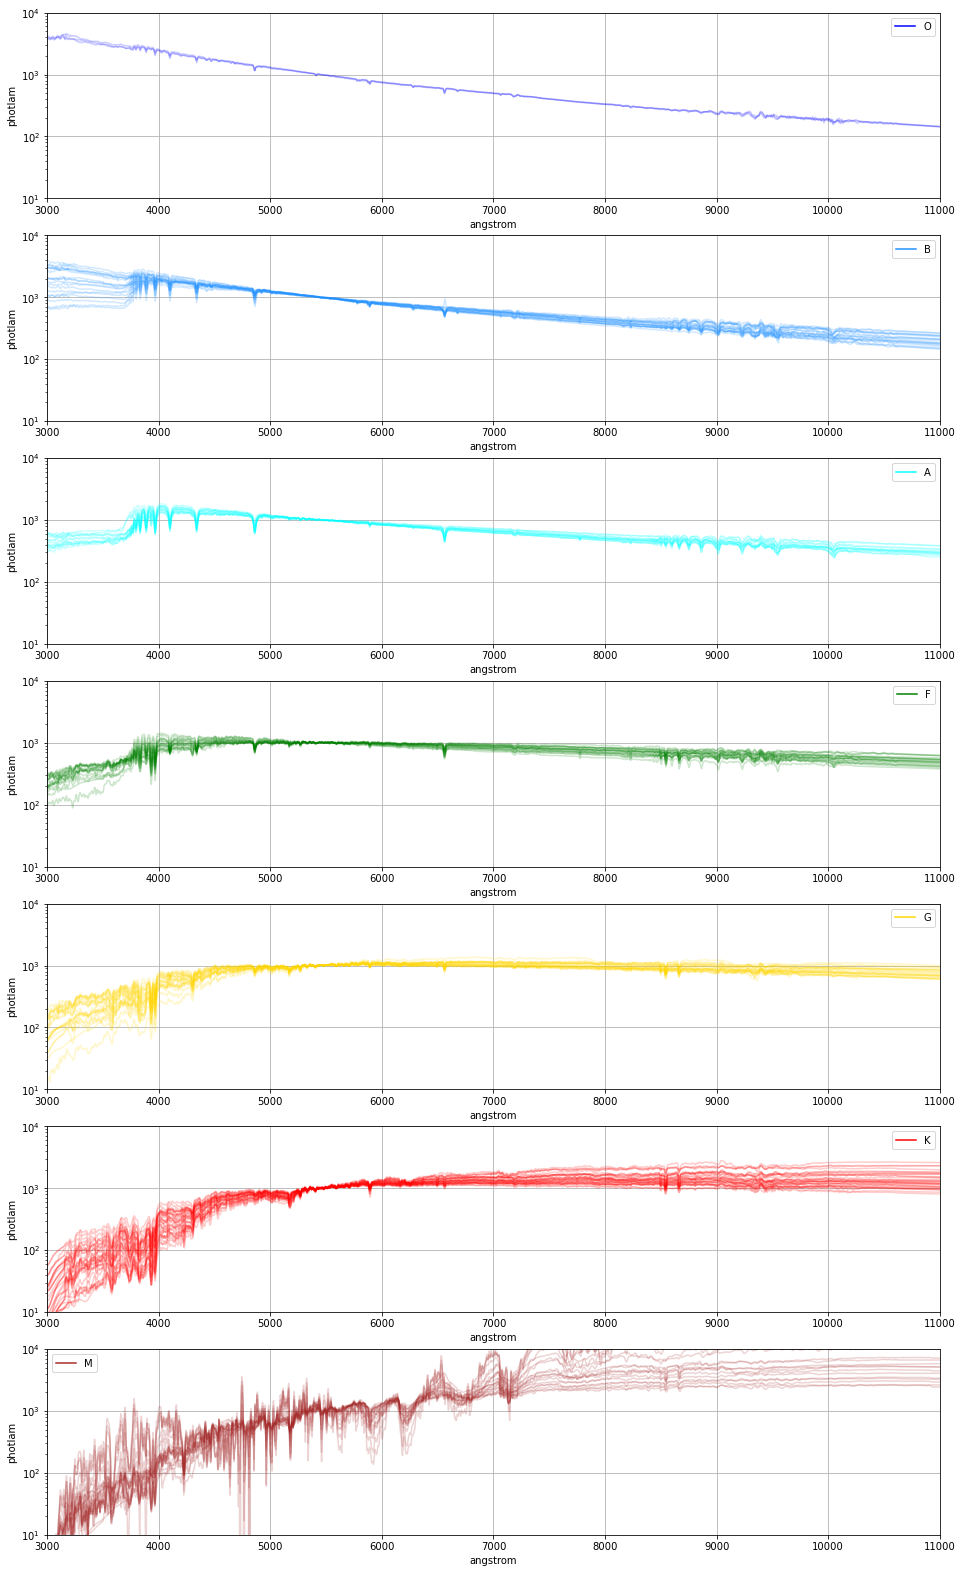

In [15]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(spec.waveunits)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

# Load LSST transmissions file 

In [16]:
datafilename = "data/lsst/old/transmissions-LSST.dat"
df=pd.read_csv(datafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [17]:
wl=df['wl'].values
U=df['U'].values/100.
G=df['G'].values/100.
R=df['R'].values/100.
I=df['I'].values/100.
Z=df['Z'].values/100.
Y4=df['Y4'].values/100.

lsst_bp = []
lsst_bp.append(S.ArrayBandpass(wl*10, U , name="u"))
lsst_bp.append(S.ArrayBandpass(wl*10, G , name="g"))
lsst_bp.append(S.ArrayBandpass(wl*10, R , name="r"))
lsst_bp.append(S.ArrayBandpass(wl*10, I , name="i"))
lsst_bp.append(S.ArrayBandpass(wl*10, Z , name="z"))
lsst_bp.append(S.ArrayBandpass(wl*10, Y4 , name="Y"))

In [18]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

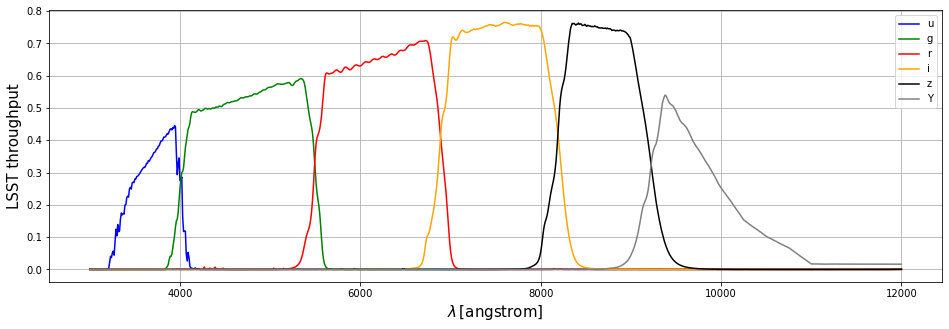

In [19]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

We find a leakage at higher wavelengths for some filters that impacts the colour values of the M type stars 

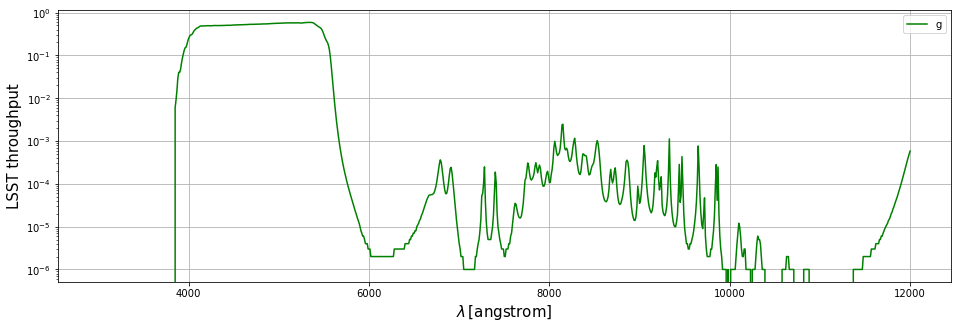

In [20]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
index=1
ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
ax.set_yscale("log")
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

Let's try with a more updated version of the throughputs. We are given only the total passband and the atmosphere that was used to generate them (https://github.com/lsst/throughputs/tree/main/baseline), so in order to have the throughputs we need to divide the passbands by this atmosphere 

In [21]:
total_passband_path = 'data/lsst/'
total_passband_label = 'total_{0}.dat'
atm_lsst_file = 'atmos_std.dat'

In [22]:
atm_lsst = np.loadtxt(total_passband_path+atm_lsst_file)

Now, we write the passbands in pysynphot format: 

In [23]:
wl = atm_lsst[:,0]*10.

lsst_bp = []
for f in filters:
    passband_ = np.loadtxt(total_passband_path+total_passband_label.format(f.lower()))
    assert (atm_lsst.shape==passband_.shape)
    throughput_ = passband_[:,1]/atm_lsst[:,1]
    lsst_bp.append(S.ArrayBandpass(wl, throughput_ , name=f))



/tmp/ipykernel_29196/1969671528.py:7: RuntimeWarning: invalid value encountered in true_divide
  throughput_ = passband_[:,1]/atm_lsst[:,1]


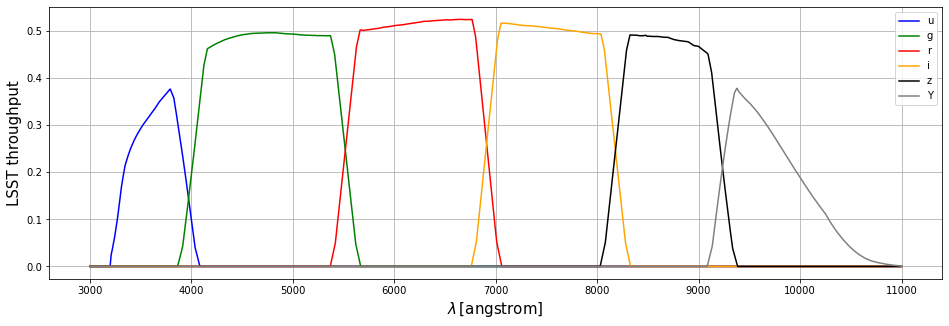

In [24]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()
plt.savefig(os.path.join(outdir_plots0,'LSST_throughputs.png'))

In [25]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [26]:
wl_lsst = lsst_bp[0].wave

# Compare with hardware.dat 

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [27]:
variable_param = 'pwv'
am0 = 1.2
cloud0 = 0.0

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [28]:
param_dist = 'linear_distribution-discrete'

In [29]:
outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [30]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [31]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [32]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [33]:
wl_t = data[0][n_atmp:]*10.

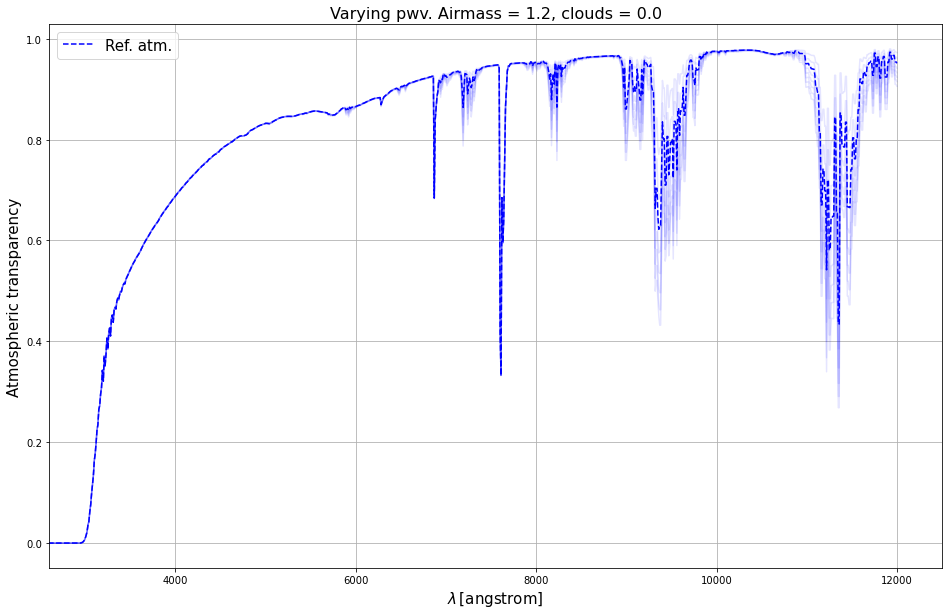

In [34]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of simulated atm values

In [35]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [36]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [37]:
var_index = params_index[variable_param]

In [38]:
#data[1:,1]
data[1:,var_index]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

(array([0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0., 0.]),
 array([-0.5       , -0.41666667, -0.33333333, -0.25      , -0.16666667,
        -0.08333333,  0.        ,  0.08333333,  0.16666667,  0.25      ,
         0.33333333,  0.41666667,  0.5       ]),
 <a list of 12 Patch objects>)

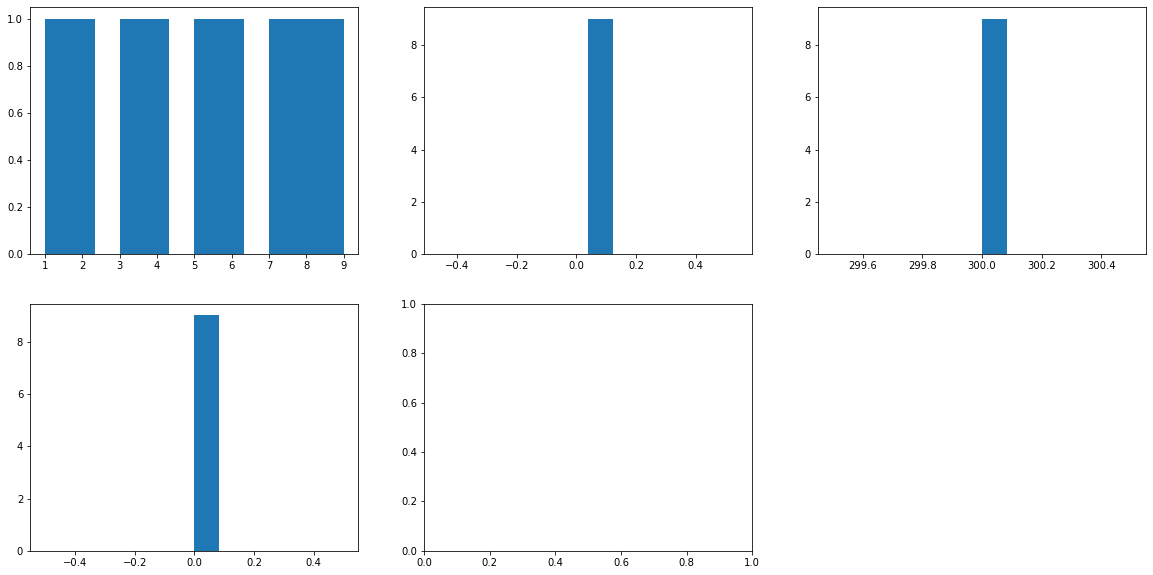

In [39]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)
ax5=fig.add_subplot(235)

ax1.hist(data[1:,0],bins=12)
ax2.hist(data[1:,1],bins=12)
ax3.hist(data[1:,2],bins=12)
ax4.hist(data[1:,3],bins=12)

# Select data for variable parameter of these simulations 

In [40]:
atm_vals = data[1:,var_index]

In [41]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [42]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    atm_transp.append(atm_i)

In [43]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [44]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [45]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [46]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(u * Atm. transp. 1)


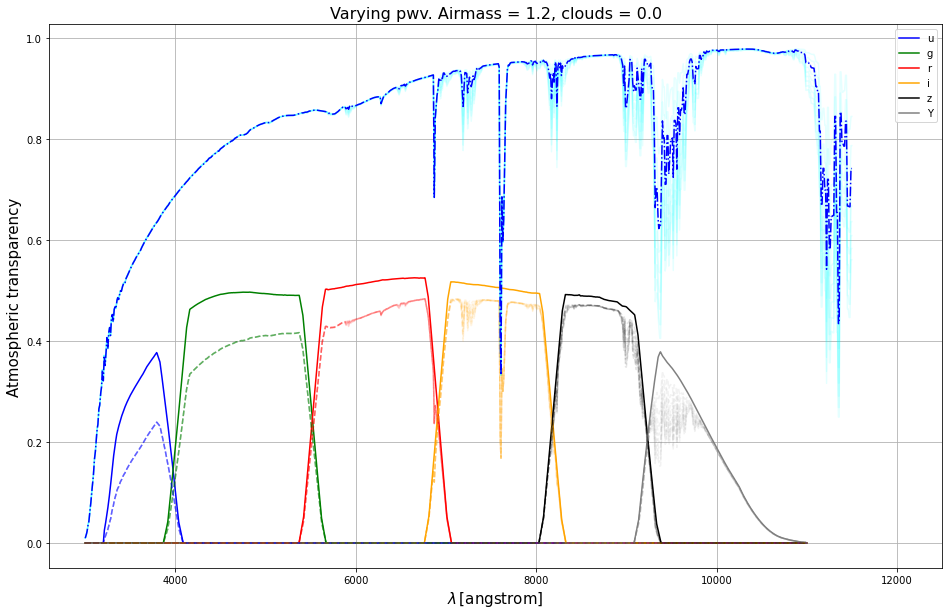

In [47]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [48]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

1.0 9.0


In [49]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [50]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

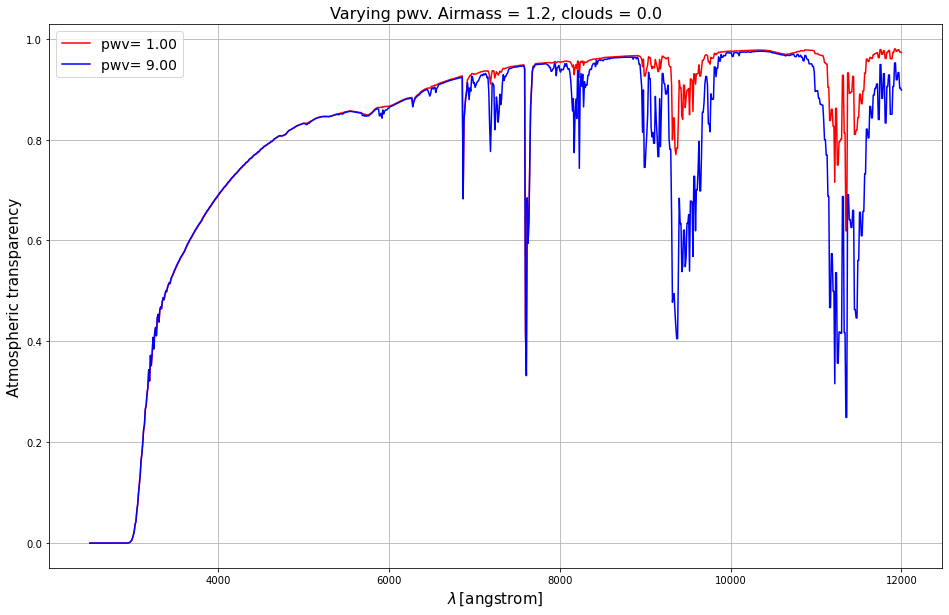

In [51]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [52]:
# Example with one spectrum 
test_type = 'A'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]

In [53]:
# It seems this galaxy is a small enough place to end up choosing again, just by coincidence, Vega as example star 
vega = S.Vega
vega.convert('photlam')

photlam


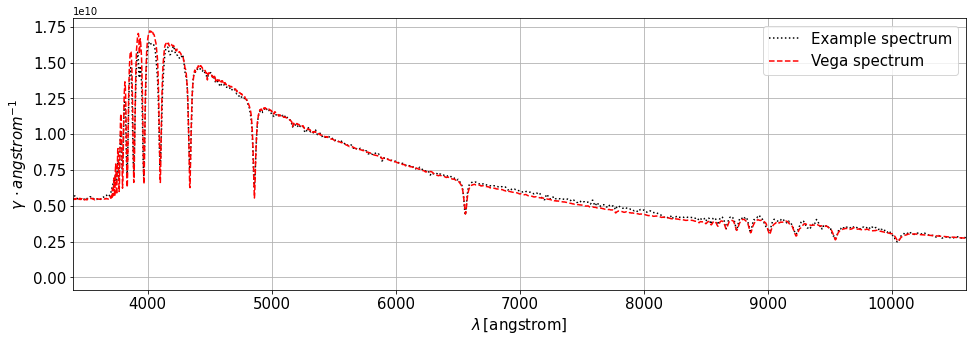

In [54]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0,label='Example spectrum')
plt.plot(vega.wave,vega.flux*Seff*exptime,ls='--',color='r',alpha=1.0,label='Vega spectrum')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(example_spec.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

Let's make the example spectrum pass through the atmosphere and through the total passband (atm. x throughput) 

In [55]:
obsatm_dict = {}
for isim in range(n_sim):
    obsatm_dict[isim] = []
    obsatm = S.Observation(example_spec,atm_transp[isim],force='taper')
    obsatm_dict[isim] = obsatm

obstotal_dict = {}
for filter in filters:
    obstotal_dict[filter] = []

#for filter in lsst_bp:
for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal = S.Observation(example_spec,total_passband[filter][i],force='taper')
        obstotal_dict[filter].append(obstotal)

(Atm. transp. 1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 3) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 4) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 5) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 6) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 7) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 8) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 9) does not have a defined

u
g
r
i
z
Y
photlam


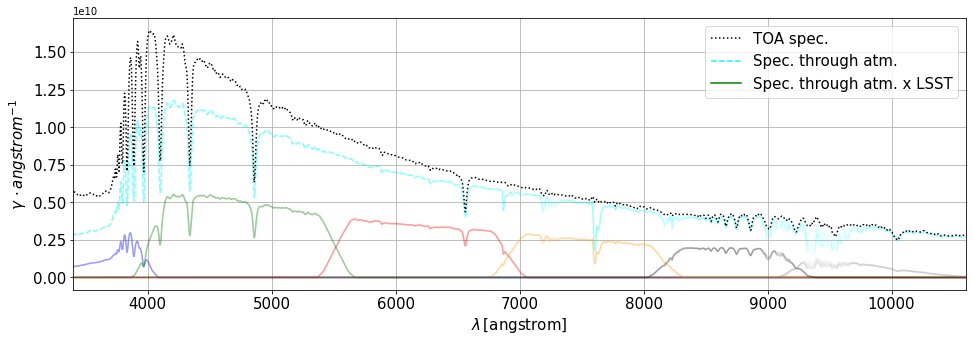

In [56]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    obsatm = obsatm_dict[isim]
    ax.plot(obsatm.binwave,obsatm.binflux*Seff*exptime,ls='--',color='cyan',alpha=0.07)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls=':',color='k',label='TOA spec.')
plt.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

This was an example of how the spectrum looks like when passing only through the atmosphere and through the total passbands. For our calibration purposes, what we actually want is to have the spectra passing through either only the troughput (as if the telescope was on space) and through the total passband (ground-based telescope). Now let's pass all spectra through the throughput and through the atmosphere 

In [57]:
# Spectra through atm x throughput 
obs_dict = {}
#for sed_ in list(sed_dict.keys()):
for st in spectral_types:
    print(st)
    obs_dict_ = {}
    for si,spec in enumerate(spec_by_type[st]):
        filter_dict_ = {}
        for filter in filters:
            filter_dict_[filter] = []
            for i in range(n_sim):
                obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
                filter_dict_[filter].append(obs_spec)
        obs_dict_[si] = filter_dict_ 
    obs_dict[st] = obs_dict_


O
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [58]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(obs_dict[test_type].keys()))
#print(len(obs_dict[example_spec].keys()))
print(len(obs_dict[test_type][test_spec].keys()))
print(len(obs_dict[test_type][test_spec]['u']))
print(n_sim)

131
7
13
6
9
9


In [59]:
# Spectra only through throughput (as if telescope was in space) 
obs_dict_t = {}
for st in spectral_types:
    print(st)
    obs_dict_t_ = {}
    for si,spec in enumerate(spec_by_type[test_type]):
        filter_dict_ = {}
        for filter in lsst_bp:
            obs_spec_t = S.Observation(spec,filter,force='taper')
            filter_dict_[filter.name] = obs_spec_t
        obs_dict_t_[si] = filter_dict_ 
    obs_dict_t[st] = obs_dict_t_
    

O
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset 

In [60]:
print(len(sed_dict.keys()))
print(len(obs_dict_t.keys()))
print(len(obs_dict_t[test_type].keys()))
print(len(obs_dict_t[test_type][test_spec].keys()))

131
7
13
6


In [61]:
obs_dict_t[test_type][0]['u']

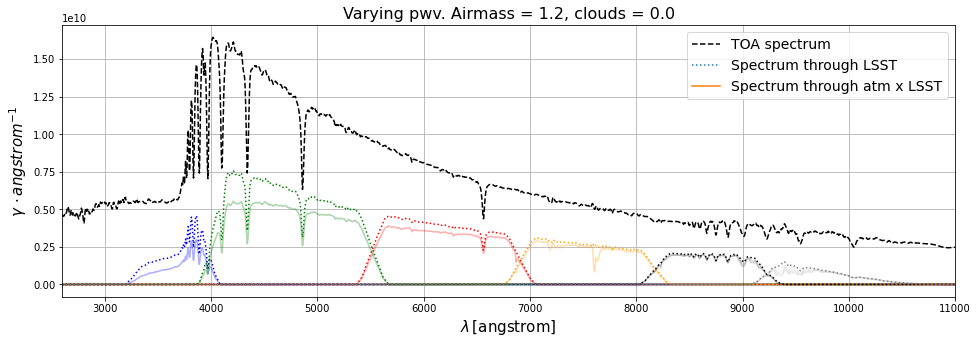

In [62]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#sed_dict[example_spec].convert('photlam')
spec_by_type[test_type][test_spec].convert('photlam')
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(obs_dict_t[test_type][test_spec][filter].wave,obs_dict_t[test_type][test_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = obs_dict[test_type][test_spec][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)

plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_toa_throughput_total_passband_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Calculate magnitudes with my own function 

Physical constants 

In [63]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [64]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [65]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [66]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [67]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

In [68]:
def myAB(spec,passband,filter):
    f_units = str(spec.fluxunits)
    if f_units!='flam':
        print('ATTENTION: converting flux units to flam')
        spec.convert('flam')
        
    observation = S.Observation(spec,passband,force='taper')
    nan_mask = np.isnan(observation.flux)
    
    num = np.trapz(observation.flux[~nan_mask]/observation.wave[~nan_mask],x=observation.wave[~nan_mask])
    #obmag = -2.5*np.log10(num)
    
    spec.convert('photlam')
    
    #print(num)
    
    #flatsp = S.FlatSpectrum(f_ref,fluxunits='fnu')
    #flatsp_vals = np.ones(len(spec.wave))*f_ref
    #flatsp = S.ArraySpectrum(spec.wave,flatsp_vals)
    
    flatsp_nphot = ABnphot(spec.wave)
    flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')
    
    flatsp_.convert('flam')
    ab_obs = S.Observation(flatsp_,filter,force='taper')
    den = np.trapz(ab_obs.flux[~nan_mask]/ab_obs.wave[~nan_mask],x=ab_obs.wave[~nan_mask])
    
    #print(den)
    #print(num/den)
    #print(obmag)
    mab = -2.5*np.log10(num/den)
    print(mab)
    return mab

In [69]:
# This function gives the flux of an AB source in photons / s / cm^2 / Angstrom 
flatsp_nphot = ABnphot(example_spec.wave)

In [70]:
#Let's write this in pysynphot format (note that the result will be in photlam units, then we use ABnphot as input)
flatsp = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [71]:
flatsp.fluxunits

photlam


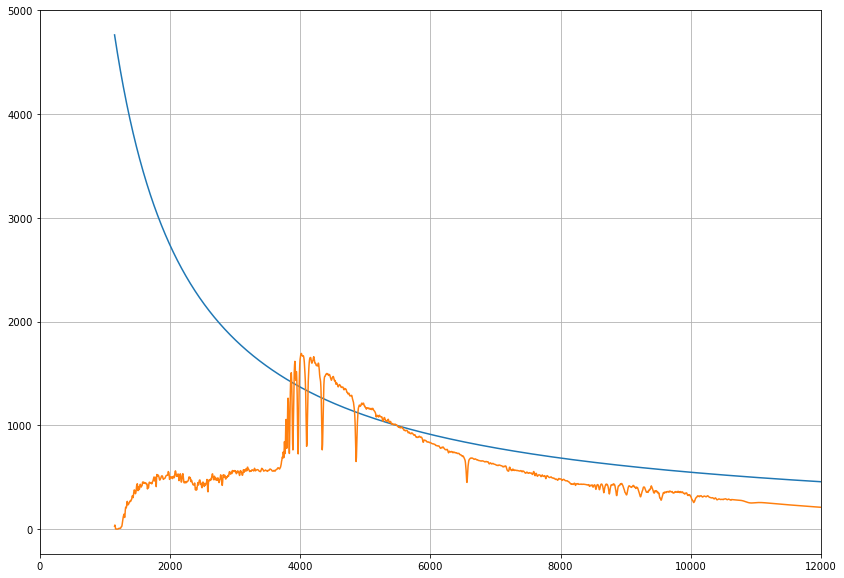

In [72]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)
plt.xlim(0.,12000.)
plt.grid()

In [73]:
flatsp0 = S.FlatSpectrum(f_ref,fluxunits='fnu')
flatsp0.fluxunits

Here we verify that creating a pysynphot AB flat spectrum and transforming it to photlam gives the same as directly creating the same spectrum in photlam units with ABnphot 

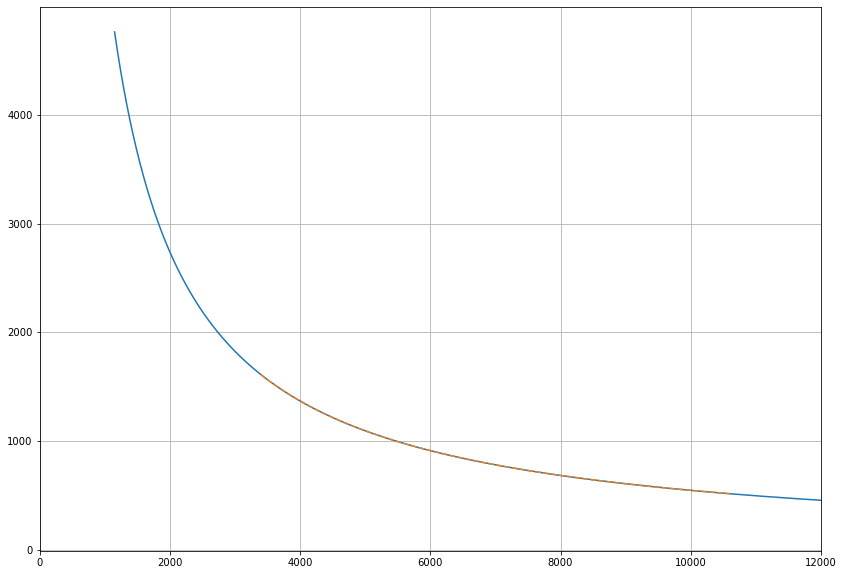

In [74]:
flatsp0.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(flatsp0.wave,flatsp0.flux,ls='--')
plt.xlim(0.,12000.)
plt.grid()

To further check it, let's transform it to flam and compare with the analytical expression: 

$$F_{\lambda} = F_{\nu} \frac{c}{\lambda^2}$$

In [75]:
flambda = f_ref*c_light/flatsp.wave**2.

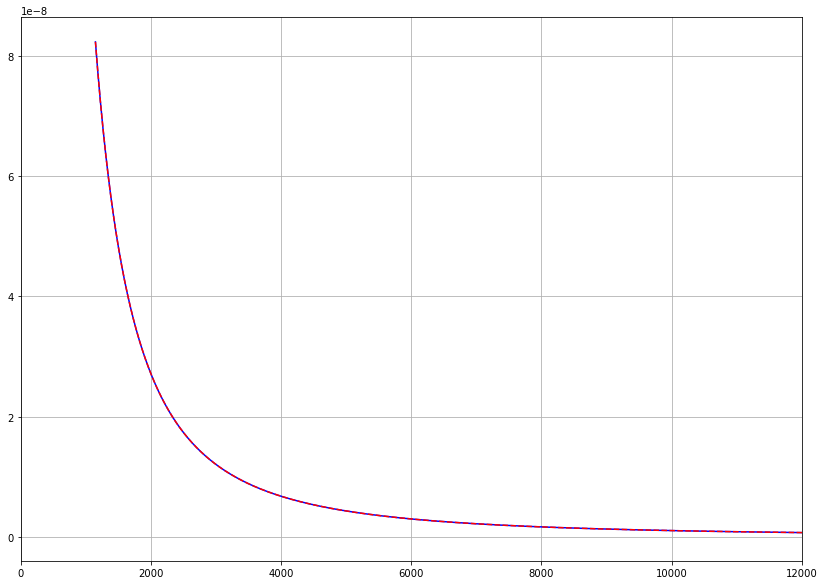

In [76]:
flatsp.convert('flam')
flatsp.waveunits
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux,color='b')
plt.plot(flatsp.wave,flambda,color='r',ls='--')
plt.xlim(0.,12000.)
plt.grid()
flatsp.convert('photlam')

Now we check that the AB magnitudes are zero for the flat AB spectrum (they have to be through any filter, by definition) 

In [77]:
for filter in lsst_bp:
    myAB(flatsp,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of 

We check the same for the total passband. Note that, given the definition of AB magnitudes that we have implemented, the denominator only considers the throughput of the telescope, even when the spectra pass through the total passband, since the "reference" we want to compare to is when there is no effect of the atmosphere, but in any case the light passes through the telescope, so we consider the telescope's throughput to be the reference (i.e. as if it had a transmission = 1) with respect to which the flux is attenuated. Therefore, the following AB magnitudes of a flat AB spectrum should be different from (greater than) zero  

In [78]:
for fi,filter in enumerate(filters):
    myAB(flatsp,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.605048695874859
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26122006546925514
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1405209361914125
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The 

Now, let's see the AB magnitudes of the example spectrum with myAB function. To better understand it, we can compare the AB spectrum and the example spectrum (Vega) flux amplitudes in each range of wavelengths (see plot below) 

photlam


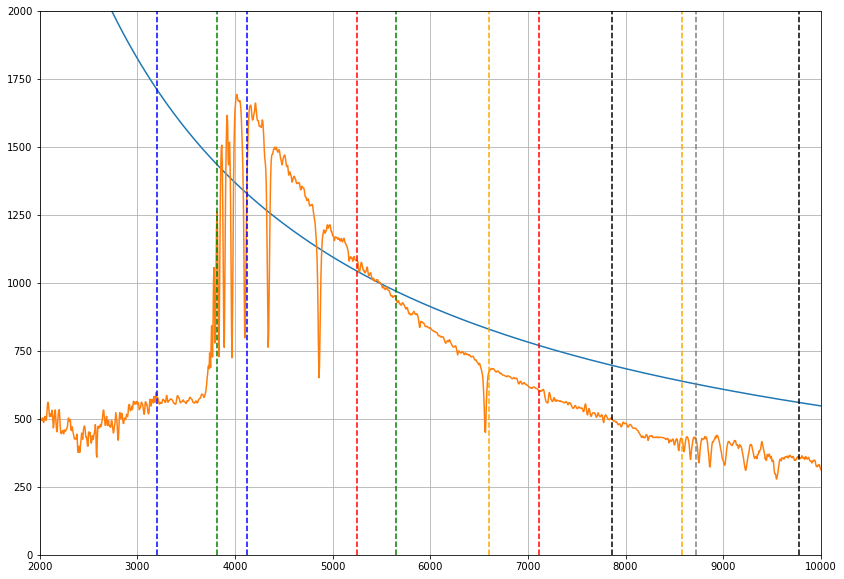

In [79]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])

plt.xlim(2000.,10000.)
plt.ylim(0.,2000.)
plt.grid()

In [80]:
for filter in lsst_bp:
    myAB(example_spec,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.765021086705792
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09951151871534347
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12690586603750892
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined 

In [81]:
for fi,filter in enumerate(filters):
    myAB(example_spec,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3267931783528546
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.16359894286507842
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2693968505200761
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The

# Calculate magnitudes and colours

We compute the magnitudes for the spectra of each spectral type for each atmosphere 

In [82]:
# Magnitudes of spectra passing through atm x throughput 
mag_dict = {}
mag_dict_ref = {}
for st in spectral_types:
    print(st)
    
    mag_dict_st = {}
    mag_dict_ref_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        mag_dict_ = {}
        mag_dict_ref_ = {}
        for fi,filter in enumerate(filters):
            mag_dict_[filter] = []
            for i in range(n_sim):
                #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
                mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
                mag_dict_[filter].append(mag_ab_)
                
            #mag_dict[sed_] = mag_dict_
                    
            mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
            mag_dict_ref_[filter] = mag_ab_
        mag_dict_st[si] = mag_dict_
        mag_dict_ref_st[si] = mag_dict_ref_
    mag_dict[st] = mag_dict_st
    mag_dict_ref[st] = mag_dict_ref_st
        

O
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17666368088945927
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17667498624140063
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1766882177887075
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat tabl

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3862369660039273
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38288861336823715
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7191790796677188
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.72208738470

((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2452187957655751
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08842064981970132
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08843193673634468
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4067827499946951
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.40343173305995295
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.716704516462145
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.719594301281

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3909715870441164
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4077002099824414
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2822805824341763
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10011936525

0.3775210681855654
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3778796503062758
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3745266478856806
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7146023958784199
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the 

1.339591135669107
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3589748202336742
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3757253333253678
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.250176637600594
B
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the 

0.3800192550793108
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3766668238239883
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6839602910101157
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6868408011496638
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3074632965530468
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1797325335620399
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15741715422556843
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15740592029

0.3466942693912288
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.634444919138665
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6373174149677209
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6400902940259077
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the w

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.200172133071765
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.073967878582468
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.43160348740874643
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4315924210605

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3413745293670192
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3426849407199222
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3430450921940741
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.339676449865

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0344530664219822
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0554329789936436
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0750828396573402
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.094415903749

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31189923398712804
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3122134463380644
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3126315271364733
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31328403070

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0081604176348877
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8819273740427611
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.949900086994907
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9498893479317

0.2807868384426771
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2821002170083792
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.282461087098842
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2790850803721739
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the w

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8334599361235748
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8528898438479783
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8720132387855024
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.888515910086

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.45570384131367003
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.45839458674567357
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4610061240056669
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4637062340

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15067962463604373
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.04295210782038106
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.042938459096167086
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.04292

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6562786853187743
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.65870065292129
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6414977568007021
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.82129539128104

0.8702200287924473
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8701088305908578
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8729765907884732
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08259400444774784
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6216489383917694
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6267008516286278
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6325197368826084
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.636705660816

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.006867800105149342
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.006855876714426568
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0068909219342322085
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8420330554956248
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8469141122987245
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8518623498680324
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.857585909844

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.35361501724881955
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.35392612763642295
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.35423733608443425
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.354549474

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1290560151461468
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0034071010924075
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6649431768256193
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.664932197695

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5247128101843294
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5285312655167893
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5309375916753061
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.513837320210

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1089293825089197
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1087481811833282
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1081063138537957
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.106262177535

0.47404024484556406
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4767221325264923
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.47932561046501515
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4820183480790715
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in th

0.2450699088155978
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2450586851549119
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24504554818919372
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24502968351279672
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6083918059226547
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6112554364092093
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6140207455677114
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.616698410356

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1863259270761515
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.062174125748601
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5431585616207326
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5431475043215

0.30241925517497326
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.30278091605365537
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2994012556348972
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5367641595552917
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in th

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.06779038182795
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0843666385466941
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9600312570425908
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08173075463205

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36638322932342954
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3667428427332655
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36337791349425597
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6072058703

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.201996344360317
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2219723212197713
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.241607954130143
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.25859648228055

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3194594728546574
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3198235821599881
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31642367083863876
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.53106762446

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1465005196332214
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.166008726442408
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1828703654787434
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0563732289628

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2937726068894468
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2944259036284879
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2957392852016143
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.296099843683

1.0032080165522153
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.024169413142539
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0438019328844688
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0631187136472127
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.28406921738558083
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.28448857175374287
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2851434695977364
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2864617616

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.769879908776306
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7955757650835711
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8185261534727559
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8395525792683

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.28264593657027653
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2833003267839502
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2846178563707632
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.28497814877

0.6973144769279992
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7201287355915971
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7410318375465772
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7606075823704371
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27172526480067327
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27303997760190013
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2734004938387405
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2700244346

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7291972655577774
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7500440333685653
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.769567820610566
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7887801019094

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2559960448170006
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.25641624654487505
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.25707160153439057
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2583890099

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6384679813058267
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6633259744638205
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.685527019710279
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7058711576843

0.23165539499326582
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2320759229225834
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23273190841911118
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23405100382598515
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in t

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6325226264311646
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6545239121829693
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6746975154166006
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.693608528941

0.2226500579670248
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2233066802119223
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22462718661284437
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2249893525177506
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5464479852630509
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5658076942268034
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.582528921650497
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4570397156441

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.17911793605260656
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18044475586572017
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18080978772311243
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.177396312

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4191737679149743
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4384971815494932
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4575189484032038
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.473923054648

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26944799523117224
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26980768168192626
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2664366903972968
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4223861321

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.748279312375878
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7679921389752633
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7873806021201936
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8041331779972

((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23688106065401832
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23724380050456845
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23385020347518515
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6419297172038811
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6587310883729924
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.532647240312893
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2593509751020443
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2559756322009023
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4110000505836807
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.413875542024

1.5239727433556582
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.523962196719072
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5239498457223464
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5239349250366006
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22206729608155287
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3462103828158925
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.34908129839412333
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3518531176

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7051804231491452
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5811210514153478
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5703366294382142
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.570326006353

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20958220899769442
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20618537445558338
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2663895848731306
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2693001074

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.572385107670859
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4466935989820378
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6399552595928026
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6399446285976

0.17061552782549794
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.17194266214772452
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1723075080357061
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.168894560187237
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the

0.4019974161121825
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.42263757312328
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4419692738035283
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.46100242815881715
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24961878667568316
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2500380388928474
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2506930859002545
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.25201237567

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6831276927452494
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7023078360451649
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7188637245096459
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.594659310358

0.21038530691603308
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3072693345959824
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31014239068750454
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3129161153695837
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in th

0.684890347471143
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5606258146326386
F
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6458126201651193
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6458018503748575
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12900099269496518
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08971728955793394
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09252753938207942
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.095240718

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2633068800912243
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.685351349371178
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6853405357281217
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6853278783076

0.026888184012268022
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.029640383267636815
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.032304007489290514
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03488898794326705
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset 

1.7236656256726448
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7236460902431654
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.723460744320299
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7228041833444994
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the w

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0004492665255581749
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.003031952584348908
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.005703381050617462
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.00862

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6469535140435778
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6468424857512716
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6497059863602936
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.464884905990

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.019713736256523486
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.040402396315110264
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.034086525300815074
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.02

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4748147499302212
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.47483541811073
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.47485575053349055
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4748756459231

-0.09331918449575069
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08812352774749829
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08307575153551724
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07797460214543304
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5015919246532053
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5014918081524721
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5011601643777704
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.501162577206

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11714180298183753
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11121022226898297
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10691757268327808
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13835

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5220635876687483
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03188906734004967
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.032212910340109535
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.032536309

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13033059791744764
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1017418252914719
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0769734463324554
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0548571

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.042303492927353505
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04262706916141555
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0429501928355835
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.043273296

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03902471054437329
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.010127394699184035
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.014907276751138659
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03726

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.01914417012067821
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.01946952811616225
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.019794418241375504
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02011927

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1454919193133194
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11679933518658259
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09193504081690745
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.069730

((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11009072335750802
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11041061596925833
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11073010319352047
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1402641203854239
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.17613771394200464
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20535635780174058
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2306714227

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4275655700847516
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07788757855511147
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07820929054194813
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0785305751

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.019487417074939513
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02662298416854569
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.061741204816945075
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.090373

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5185539977111229
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5189343997075041
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0486885950417646
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.049011683345

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12745091226196328
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10100393036842933
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06560449192022162
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03676

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.33893397881891363
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3394356604647331
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1528258926359696
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15314418965

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1636402812246825
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13266788815057545
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1709684105705107
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.20709550084

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44324481250142234
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44324497940328617
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44368651706539974
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.081778632

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04768429258861573
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.05190850165571953
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02096134759831315
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.041844024

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44488059538563723
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4448809910181761
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.445320515117538
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.069177704793

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.008363269465111553
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.004070417548372124
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.035514803539824905
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.04

0.2620899563052587
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.262084626982286
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26263376241509867
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1937728893571604
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3331900125052637
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3374000521373424
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3065756507433949
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.330943251946

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3881349371569725
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38813332968228914
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38861075638423775
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1204630922

((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15344357070059944
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12246790890214143
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12681818882421658
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1710528166925357
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1713711500147727
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.17168951193032916
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.17200874549

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19195711027215037
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.22768671030505955
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2568248962680959
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2820831331

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12924421291849275
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.129563730203018
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.129883269040107
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1302036754017

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0984462537341891
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1339066261990451
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.16280534667933605
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18784756280

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04549692713175641
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04581874639295469
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.046141412484044575
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04657075

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.007331959200505798
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03623988996451736
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.061279021425426766
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0836302

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5350984639104296
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.024686504091116716
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02500990666038379
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.025332853

-0.2218381492763426
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19322381666399294
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.15786271444556657
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12901636178336948
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.527651420989219
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5280381101198937
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.020961761217677188
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02128582366

-0.19874250902357793
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19284589552943504
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18858666229616994
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2197931692710563
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset 

0.5461281762325042
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5460369054068731
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5457295998346635
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5457340001665858
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.265807155282975
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2606431982106513
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25472176872639296
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25044159

((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5765304001542281
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5765228881575408
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5764345739809895
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

-0.27828046127992145
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27265783127834786
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26740317378871703
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2623026015654677
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6052328884720646
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6052543193392081
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.605248823748485
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6051664885397

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.30400347513101084
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.298439279826216
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29323615265702674
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2881814

0.5904346130765734
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.590456361970151
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5904774216699944
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5904705687477902
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2563232860895181
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25037792293344285
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.24485591425495892
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.239690

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6128965273342343
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6129192746227948
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6129417469336073
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.612963867571

-0.21750673522202388
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.30938689645093576
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3028004995960714
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29676005074095
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in 

0.645434667617484
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6454578083467638
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6454806892866216
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6455032396374663
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.38828867228464703
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.38232569307968534
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3767919817052999
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.371619

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5467862001715091
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5468072624421951
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5468276029492363
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.546818789605

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2048956423783453
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19827704873334429
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19220970637909401
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.186581

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5936133068638767
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5936357080906248
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5936577551781306
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.593679135790

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2578130426931412
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2526271884905158
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.24759017173589642
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2425005

0.6432907486546563
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6433128076067329
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6433094660529655
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6432336158989111
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.326716611269522
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3214944389103614
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.316424970641484
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3113060369

0.6877371625111944
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6877604988393791
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6877832452135899
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6877818954440124
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the 

-0.46631280154267934
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45963742543361247
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45352060045836207
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44784784765104424
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5962327405094222
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5962548481443313
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5962765891545792
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.596297644644

-0.29854855632146404
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2929629521998725
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2877452757324606
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2826813025732589
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in

0.7238675770657341
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7238917728894938
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.723915427226476
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7239168363301558
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4455630333348144
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44052230146001514
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4354316174173764
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4295793

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6933293482658488
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6933273095409329
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6932548804199232
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.692998444522

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4494621773806956
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4443272010917181
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43914824271995656
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4332127

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7265662108512378
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7265022339268172
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.72626933000987
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.72628016918014

-0.45347317645021873
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4476488166255655
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44345875880255536
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.47419536619359265
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7655959704386682
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.765381776296862
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7653943692177836
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7656011144996

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5129935678474161
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.507861194653353
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5019692725493107
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.497717304

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7225729841224893
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.722508016102863
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7222722368519708
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7222829184354

-0.4988802235717035
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4946435745097311
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5257459155458577
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.546015012972506
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in t

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07664313575493852
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07631538920556578
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07598770353507303
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07565

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29114289438616536
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2727099846247794
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25451722074905825
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.238892

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03473345595711515
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.038212924279564284
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18913313865011822
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1862

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8267465382808816
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8267313500989824
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.826712100505972
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8265297005391

-0.24180608024464784
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23890646587036457
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23511865610539928
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23274387421156295
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.17616740947507
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8375987281353836
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8376255477440042
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.83765220219208

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.37271473170495883
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3675696544774074
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3625727437441664
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3575224

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9195075524472595
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9195264401622959
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9196153764528465
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19713255462

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5718092558340728
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5437679261808749
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5195110873406958
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49788145

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07717435593253384
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07649929929200484
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07514192258196592
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07476

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2874339457897715
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2712050126511907
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.393082872723347
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.7183976154

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08440631464634044
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08403324648499175
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08752381106672645
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.32996

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8970232526555324
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.897012295763325
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.896999485963251
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.89698399456608

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42197826559814194
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.41932928626709104
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.41643014659262184
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.41264

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.0466880681258237
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.0465768209581534
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.049446141127254
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7720047786088

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7167375860519678
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7105947493609254
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.704902181287247
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.699586959

((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.866880238767014
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8668851312073689
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8668359382186775
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8458992388753179
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8406065328756384
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8354735321497232
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.83029702

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9601847617592145
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9601435414122518
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9599747993636376
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.959990066521

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9604679065592241
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9544941485174651
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9501659353283876
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.98193426

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.063571088528136
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3538710150245985
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3535435531000047
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3532166517

((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2853463615071132
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2609224617631085
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.239124593134015
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1221136629554871
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12178443793464702
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12134617708097345
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.120666

-0.47664796455172737
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45789459404501853
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43940768984943435
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42351032524900273
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset

((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1567037518778541
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1602345179850875
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.48949484141480726
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6593404559185712
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.662472106665104
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.662461364074085
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.6624488073815

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.602239017104199
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5995254845907936
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.596900602917229
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5943544161

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1138225217849644
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1138031094238205
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1136190244827846
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.112966969873

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4280197254987219
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4251500113866362
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4213914089435298
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.41904684

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8347082979858174
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.83755537494967
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7699429403289375
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.76996844172601

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5569096529120475
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.550391803410801
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.544416123535869
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5388725339

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7932730133602549
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7932984504845129
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7933236499136042
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.793348366929

-0.6064397396657629
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6008904434826458
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5957052805928974
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.590670955412338
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in t

0.8175519394986077
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8175582959640871
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8175101661227675
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8173195828174884
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the 

((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6433316794249508
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6374063879640669
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6331226667804285
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8076846304743246
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8078614792502782
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1281693162924827
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1278420723

-0.6047487473448695
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5704977893708365
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5425885391627021
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5184093589701367
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.16196613630184192
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1615303942756497
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.16085261384409247
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.159489

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6071916736445735
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5893351297119641
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5740326495518463
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.68921415

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17916249780201265
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5744806597088244
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5717033182019532
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5690233

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.376403299847557
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.376388216285972
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.376369102097438
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.376187881580866

-0.49265648626209496
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4897709693455487
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.485996949557676
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4836376836417601
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in 

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.7032167681981325
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9125893134149168
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9126166576033606
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.912643864764

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.765082649401681
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7594721646418844
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7542327545643946
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.749149819

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9211507380990764
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9210081798785241
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9210269227351918
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.921115449114

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7850807916975506
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7798840228809016
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7739344650639961
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.76963130

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918379718889241
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918642975384715
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918739403063236
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.891835795281

-0.7701675068788938
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7657945107774684
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7978963959526724
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8721802812909232
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.980917488637818
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9808037518934014
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9808251174494906
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9808653700347

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8354510149159012
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.830332793021597
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8251729724724127
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.819258137

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0583987658930796
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0584281478087123
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0584475920428156
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.058438369036

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0302158903109861
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0239722831751332
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.018186887285795
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.012786979

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0096446467948446
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0096732186018376
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0097016893873092
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.009730048531

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7347822720847272
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.013075398138015
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0064240821126527
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.000330184

1.046345124747257
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0463744605954606
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0464037145365948
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0464327287415933
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the w

ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0341527219090896
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.028404145601516
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0230420407369392
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. Th

((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0581526858534405
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0581817824921438
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0582107972932362
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2445327571417855
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2387789502675595
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2334095240794403
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.22820771

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1067202194023031
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1066463870272594
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.106670881062235
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1066466858539

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3839465522887542
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3499314766676707
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3222631294622522
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.29831531

-0.18799937028023353
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18766958564403724
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18723017714778317
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18654834545890786
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6169205053790286
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6013401998462814
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7185867445178062
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.440899314

-0.2633336656316555
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.742379139274363
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7396874995937648
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.737088564483567
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in th

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.430454038088828
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.430438957979179
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.430419851360128
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.430238921245645

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7084644299032506
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7059810439962928
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7034055287486046
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.70057716

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.568302303481813
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.568121762030714
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.567482398157993
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.565645220512826

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.836725066561536
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8341887463726638
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8313979464499919
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.827714959

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.666483146195625
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.665836058983432
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.663976815476321
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.663866962688868

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.001235746637738
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3861389298346904
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3794198958923847
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.373270662

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0342070552716212
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0342330377658184
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0342447965512767
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.034215702073

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4024026356024886
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3964302078730795
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3921039904613843
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.42386836

1.0556989126549468
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0557192261805783
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.055762327162781
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3452770794261908
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7783715346965014
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7506887318358133
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7267247669502375
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.70534582

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3941444482479498
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.393450623149871
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.39205356789187684
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.39167189

-1.8483197145481873
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.965620970458743
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.9838371962936447
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.9838265470876433
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4931803683802864
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4906032959311577
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.488109836257023
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.485690738

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.8842768033788024
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.883643475383481
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.881823576868981
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.88171606545254

-1.6569570334878745
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6544140424759695
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6516170617811687
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.647924869347386
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in t

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.320863455248151
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.320756412863864
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.32351779033495
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.142163098611049


(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.674042153339345
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.6672345172653467
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.6609385134370065
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.655070225

1.1891453932452953
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.189174636765554
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1891938176585217
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1891866192662208
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the w

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.087794587216484
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.1218155755660026
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.4541948304485084
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.422198473

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5428430836870857
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5424464817310161
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5420498638136777
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.54153487

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.1968611299809755
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.179134850890411
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.163956245598387
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.2782577316

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3049061515001747
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.308500923568922
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0092534747546327
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.006543494

4.343740362316735
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.343727971600573
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.343712974974588
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.343693968619856
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wave

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.082175136498246
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0793819456247775
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0756954641689085
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.073423842

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.385282024070006
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0792312467185459
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0792604774694299
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0792896368182

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6273508744265182
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6218985970844222
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6166195408698436
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.61130847

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0577404367911587
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.057763562884327
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.057759485113416
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3092058296567

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.091170402079581
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0638964649869336
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0402845669244556
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.019220844

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29095574120304457
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.290227230183086
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.28879107227035705
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2883776

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.420583816395124
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.4054375719969596
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.519564580758176
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.71548281505

-1.938977545067847
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.9365982510131823
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.9341259077331683
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.9313994079972854
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in t

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4070334991971025
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4069270490144863
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4096729469246236
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.935833872660

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3818317598431813
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3745021079569417
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.367720974942434
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.361400745

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8946582526019652
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8946829051121752
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8946902223690307
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.894647940384

((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.150915201785843
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.143700046683685
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.1382082269453555
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9629084066557418
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5627179001252927
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5622376148485154
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.561759963

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.758304923232465
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.732422479348973
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.711193396719714
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.69278488654

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4262223841817461
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4257022352244663
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42518520369267343
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4246707

-5.531405604768922
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.509569489567171
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.49067953955784
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.473858192460623
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29388513816035694
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2929342371427242
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2912349740873938
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2906226

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.809078737698351
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.781093266282911
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.781082893384532
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.78107076494594

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5483058699892376
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5458033504412716
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5433791748670949
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.54102475

4.813370611331822
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.813355811222352
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.813337057171769
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.813159893408631
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wave

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5169783785058144
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5145086576203737
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5117820980170114
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.50815902

In [83]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(mag_dict.keys()))
print(len(mag_dict[test_type].keys()))
print(len(mag_dict[test_type][test_spec].keys()))
print(len(mag_dict[test_type][test_spec]['u']))
print(mag_dict[test_type][test_spec]['u'][test_spec])

131
7
7
13
6
9
1.3267931783528546


In [84]:
print(len(mag_dict_ref.keys()))
print(len(mag_dict_ref[test_type].keys()))
print(len(mag_dict_ref[test_type][test_spec].keys()))
print(mag_dict_ref[test_type][test_spec]['u'])

7
13
6
1.3267700598849657


In [85]:
# Magnitudes of spectra passing only through throughput. We define this in case we want to use the TOA observations 
# as reference, instead of a given atmosphere 
mag_dict_t = {}
for st in spectral_types:
    print(st)
    
    mag_dict_t_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        
        mag_dict_ = {}
        for index,filter in enumerate(lsst_bp):
            #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
            mag_ab_ = myAB(obs_spec_,lsst_bp[index],lsst_bp[index])
            mag_dict_[filters[index]] = mag_ab_
        
        mag_dict_t_st[si] = mag_dict_
    mag_dict_t[st] = mag_dict_t_st

O
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7893446425156457
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.35718720189872455
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23872301864840098
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defi

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19609357398759336
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4682134136651155
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6801461645329764
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8388235833696978
ATTENTION: converting flux units to flam
(u) does n

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4813783567405278
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2771935226931169
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.219185016595496
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5511217938322409
ATTENTION: converting flux units to flam
(z) does n

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44795869793317367
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6679071613559948
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8138030097411454
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5294626625231793
ATTENTION: converting flux units to flam
(g) does 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09951151871534347
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12690586603750892
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3201996853600829
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.46852522332964935
ATTENTION: converting flux units to flam
(Y) doe

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7671856545282703
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08298781509802117
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11291048046632084
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3223283925721572
ATTENTION: converting flux units to flam
(z) does

0.21870716134440282
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.320820230698807
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4139995250874111
F
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0762452331881012
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does 

-0.10071350629301944
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19851060070496182
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.19849624540631228
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.234517743307675
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) d

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.011770905317879238
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06516965612865006
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0728695992279278
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08351112541263035
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11172023077612411
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2192117196453032
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0751021071743864
ATTENTION: converting flux units to flam
(r) does 

1.5403959693096458
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3304646961362187
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1420814988233055
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2981720160298834
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does 

-0.3231627614268112
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3281448638302601
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.8624437314604392
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4011104879125483
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5338437554333166
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5487575813836
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3748694843811715
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of 

-0.43783472890327835
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45778644055092244
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.119583453353019
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6903099079187376
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.691108677320686
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6330305417929822
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.37598889859376844
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7600148038102695
ATTENTION: converting flux units to flam
(z) does 

-0.3405936789597944
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6931607822803065
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8595270352115697
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9073249977222925
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) doe

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8269420648759053
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.9043026563027388
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6326199043960218
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3166890964732282
ATTENTION: converting flux units to flam
(i) does 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7545632635724557
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3594486876688239
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7254216759357746
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9064587450730517
ATTENTION: converting flux units to flam
(Y) does

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.47083120864500094
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0395041032166872
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.323835612541953
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.829007255430681
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4798852411539234
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2775121460702965
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.677962583977997
ATTENTION: converting flux units to flam
(Y) does n

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.5287032924308104
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.791545673230594
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0375806150051428
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6705104102472961
ATTENTION: converting flux units to flam
(i) does n

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8031886849963549
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42567869391413093
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7122472050692257
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.354427518907501
ATTENTION: converting flux units to flam
(Y) does

-4.505239604294395
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.624459380966208
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4793245508311053
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5852958162530049
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does no

In [86]:
print(len(obs_dict.keys()))
print(len(mag_dict_t.keys()))
print(len(mag_dict_t[test_type].keys()))
print(len(mag_dict_t[test_type][test_spec].keys()))
print(mag_dict_t[test_type][test_spec]['u'])

7
7
13
6
0.765021086705792


Now we compute the colours from the magnitudes 

In [87]:
colour_dict = {}
for st in spectral_types:
    print(st)
    
    colour_dict_st = {}
    for si in mag_dict[st]:
        c_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict[st][si][filters[fi]])
            mag2 = np.array(mag_dict[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
        colour_dict_st[si] = c_dict
    colour_dict[st] = colour_dict_st

O
B
A
F
G
K
M


In [88]:
print(len(mag_dict.keys()))
print(len(colour_dict.keys()))
print(len(colour_dict[test_type].keys()))
print(len(colour_dict[test_type][test_spec].keys()))
print(len(colour_dict[test_type][test_spec]['u-g']))

7
7
13
5
9


In [89]:
colour_dict_ref = {}

for st in spectral_types:
    print(st)
    
    colour_dict_ref_st = {}
    for si in mag_dict_ref[st]:
        c_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict_ref[st][si][filters[fi]])
            mag2 = np.array(mag_dict_ref[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
        colour_dict_ref_st[si] = c_dict
    colour_dict_ref[st] = colour_dict_ref_st
    

O
B
A
F
G
K
M


In [90]:
print(len(mag_dict_ref.keys()))
print(len(colour_dict_ref.keys()))
print(len(colour_dict_ref[test_type].keys()))
print(len(colour_dict_ref[test_type][test_spec].keys()))
print(colour_dict_ref[test_type][test_spec]['u-g'])

7
7
13
5
1.163138307941303


In [91]:
np.save('output_files/colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),colour_dict)
np.save('output_files/colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),colour_dict_ref)

# Evaluate the dependency of the colours with the variable atmospheric parameter (for the example spectral type) 

First, we look at the dependency of some magnitudes with the atm. parameters 

Text(0, 0.5, 'Magnitude (u)')

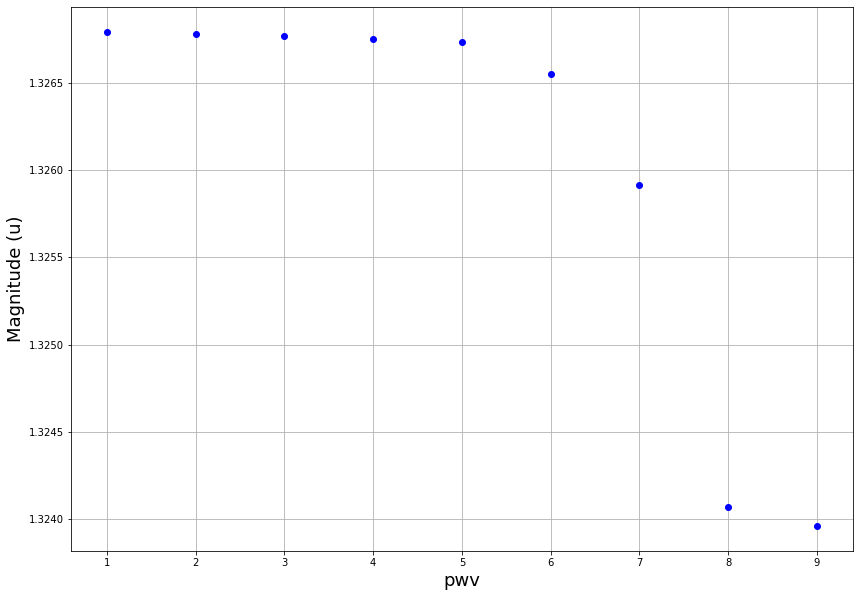

In [92]:
band = 'u'
plt.figure(figsize=(14,10))
plt.plot(atm_vals,mag_dict[test_type][test_spec][band],ls='',marker='o',color='b',label=band)
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('Magnitude ({0})'.format(band),fontsize=18)
#plt.legend(loc="best")

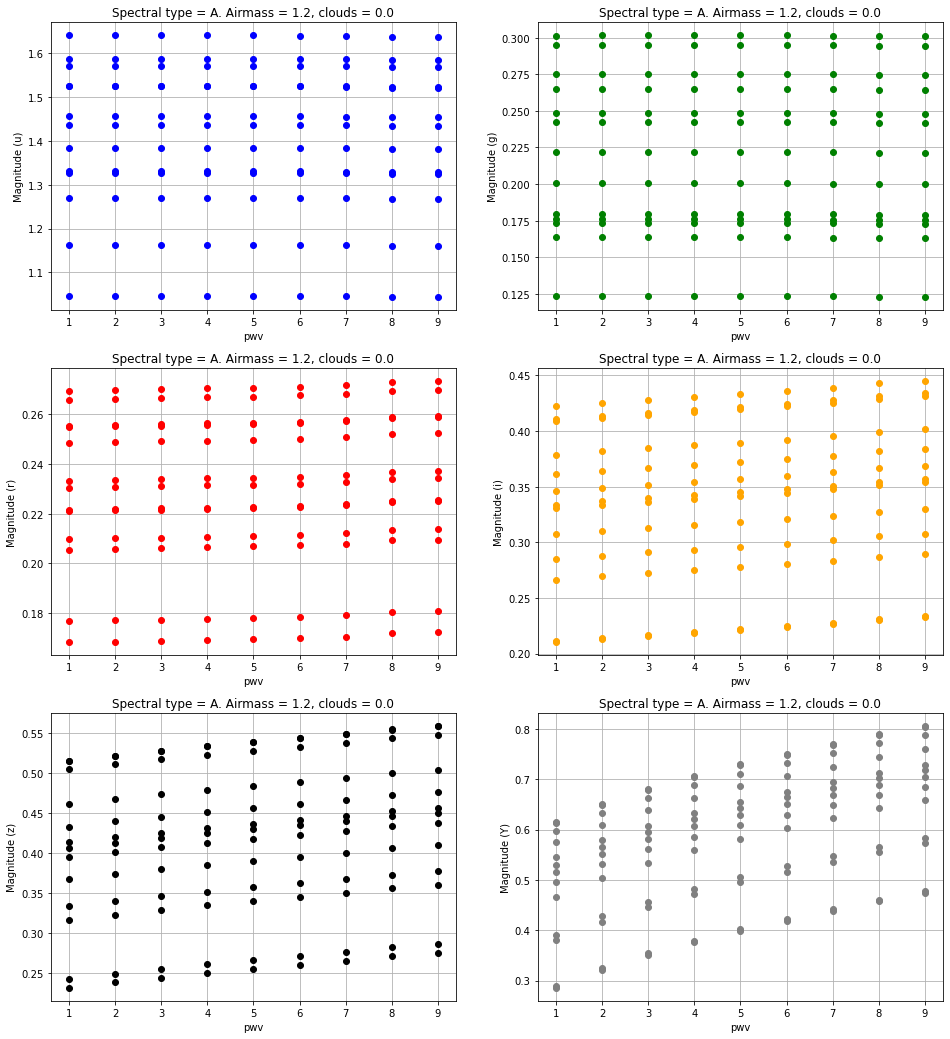

In [93]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters):
            band = filters[i]
            for si in mag_dict[test_type]:
                axs[row,col].plot(atm_vals,mag_dict[test_type][si][band],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel('Magnitude ({0})'.format(band))
            axs[row,col].set_title('Spectral type = {0}. Airmass = {1}, clouds = {2}'.format(test_type,am0,cloud0))
            i += 1
            

Now we do the same for the colours: 

Text(0, 0.5, 'u-g')

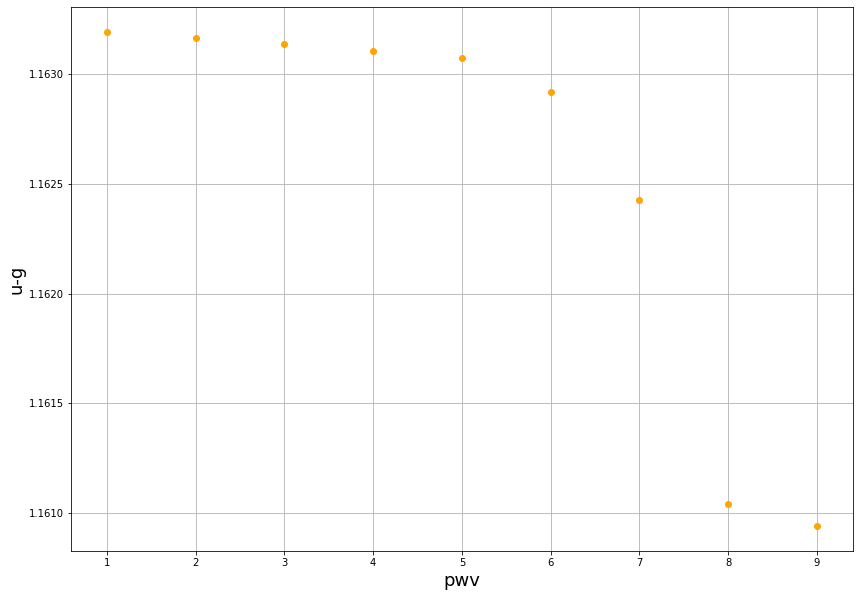

In [94]:
plt.figure(figsize=(14,10))
col = 'u-g'
color_ = colour_dict[test_type][test_spec][col]
plt.plot(atm_vals,color_,ls='',marker='o',color='orange')
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('{0}'.format(col),fontsize=18)

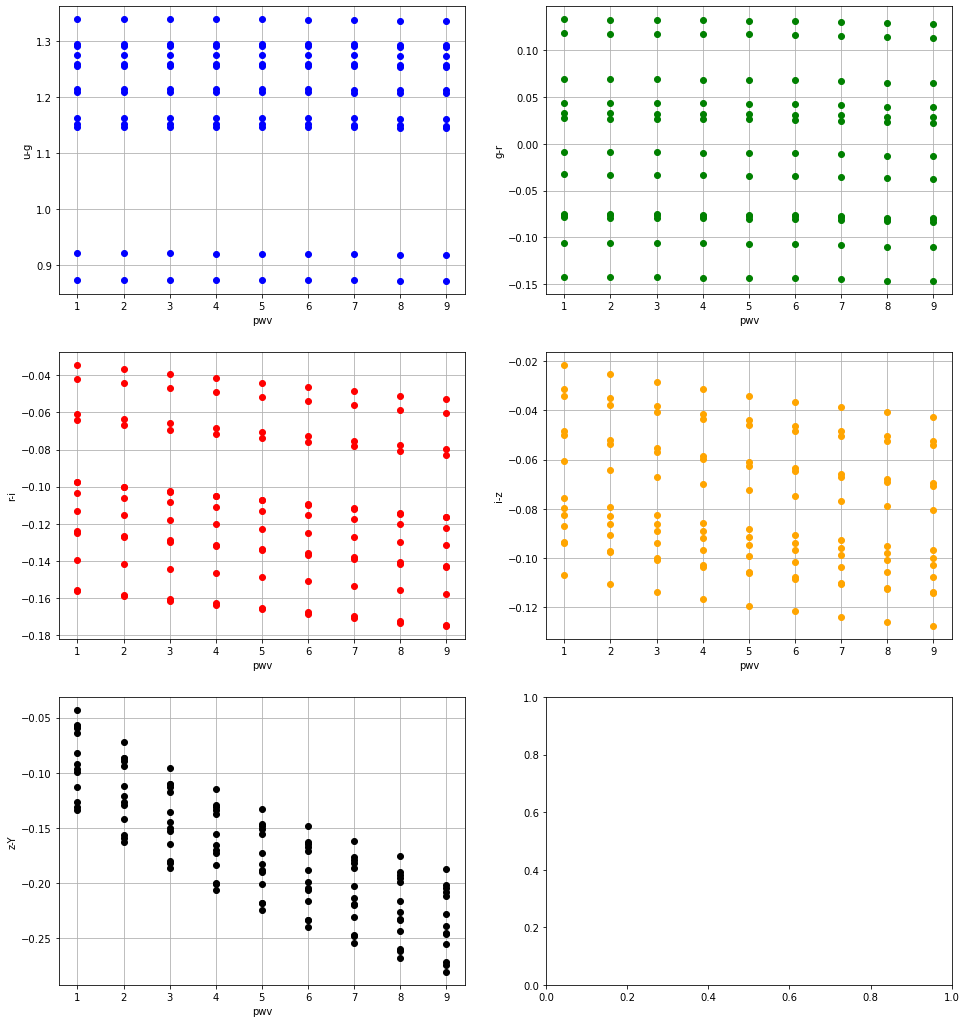

In [95]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in colour_dict[test_type]:
                axs[row,col].plot(atm_vals,colour_dict[test_type][si][c.lower()],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(c)
            #axs[row,col].legend()
            i += 1

Doing the same but with respect to the reference atmosphere, that is, $\Delta c = c - c_{ref}$: 

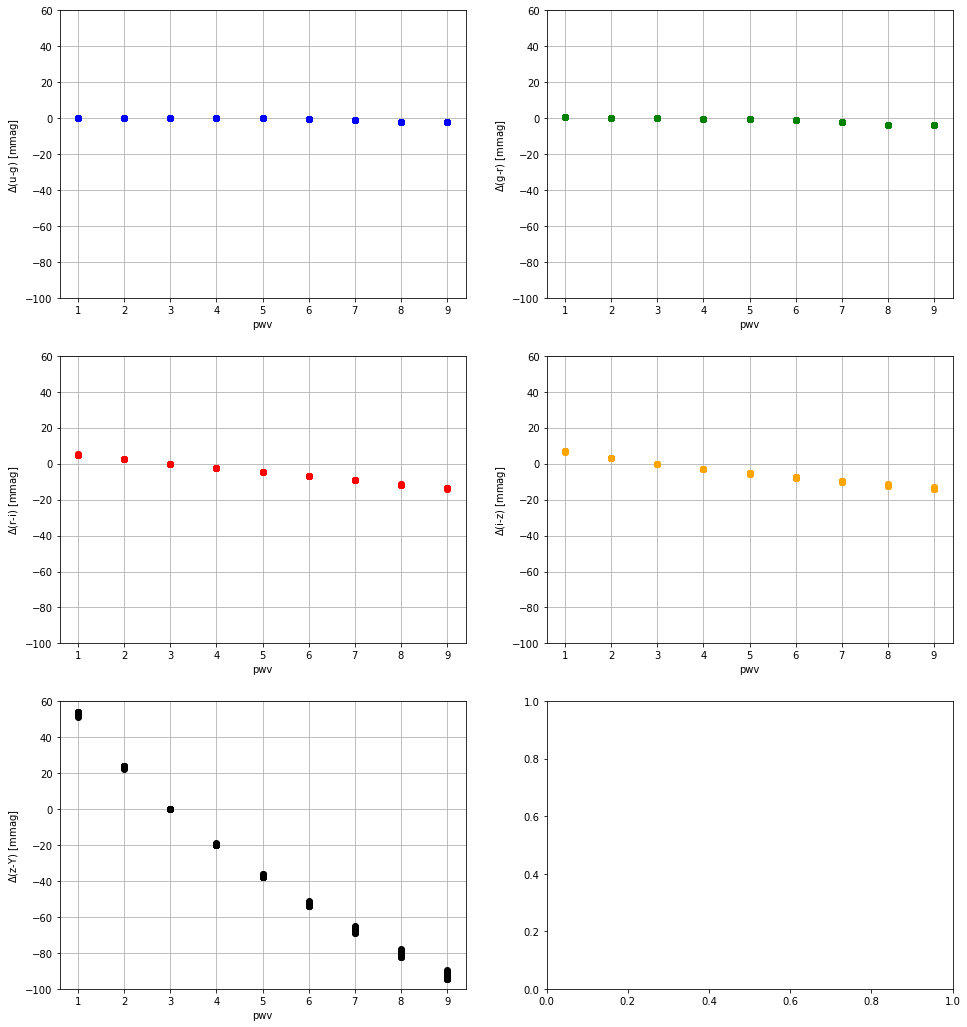

In [96]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in range(len(colour_dict[test_type])):
                #if si not in [15,16,17,18]:
                axs[row,col].plot(atm_vals,(colour_dict[test_type][si][c.lower()]-colour_dict_ref[test_type][si][c.lower()])*1000.,ls='',marker='o',color=filter_colors[i])
            
            axs[row,col].grid()
            axs[row,col].set_ylim(-100,60)
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+c+') [mmag]')
            #axs[row,col].legend()
            i += 1

# Evaluate the colour - colour plot as a function of the atmospheric parameter values 

Let's check first with the example spectrum: 

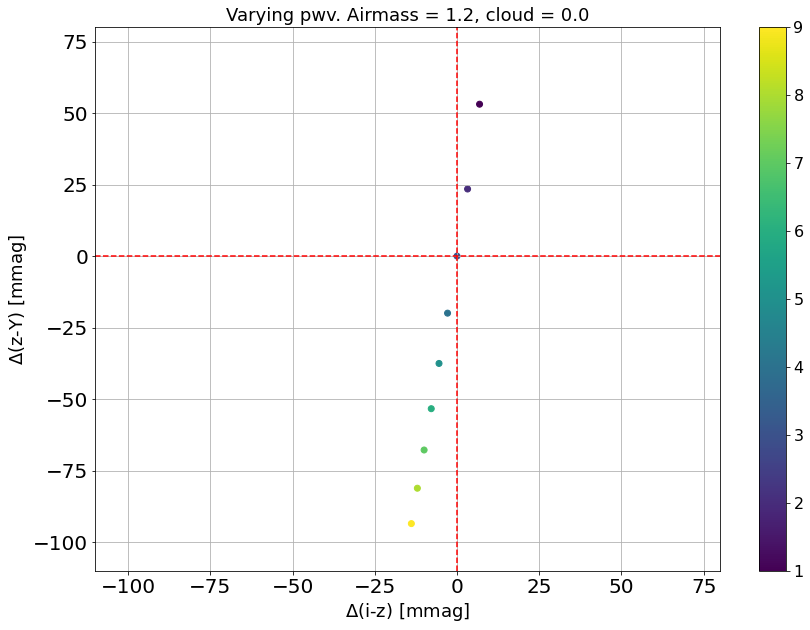

In [97]:
colorx = 'i-z'
colory = 'z-Y'
plt.figure(figsize=(14,10))
delta1 = (colour_dict[test_type][test_spec][colorx.lower()]-colour_dict_ref[test_type][test_spec][colorx.lower()])*1000.
delta2 = (colour_dict[test_type][test_spec][colory.lower()]-colour_dict_ref[test_type][test_spec][colory.lower()])*1000.
plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(-110,80)
plt.ylim(-110,80)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('Varying {0}. Airmass = {1}, cloud = {2}'.format(variable_param,am0,cloud0),fontsize=18)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_colour_colour_plot_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

Select Delta_color ranges 

In [98]:
rangex = (-110,80)
rangey = (-110,80)

Now we evaluate the colour - colour plot for all spectra of the example spectral type: 

In [99]:
save_plot = True

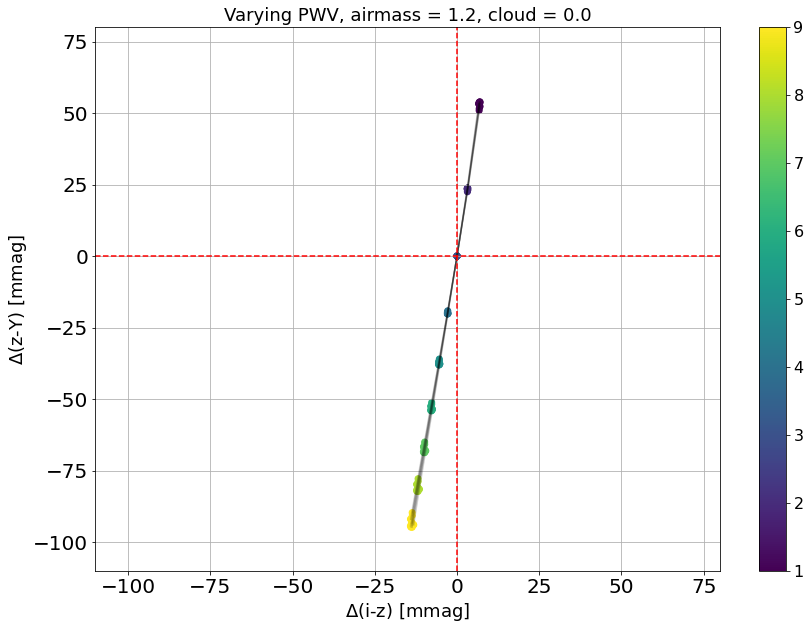

In [100]:
colorx = 'i-z'
colory = 'z-Y'
plt.figure(figsize=(14,10))
for si in colour_dict[test_type]:
    delta1 = (colour_dict[test_type][si][colorx.lower()]-colour_dict_ref[test_type][si][colorx.lower()])*1000.
    delta2 = (colour_dict[test_type][si][colory.lower()]-colour_dict_ref[test_type][si][colory.lower()])*1000.
    plt.plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
    plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(rangex)
plt.ylim(rangey)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
#plt.title('Spectral type: {0}. Number of spectra = {1}'.format(test_type,len(colour_dict[test_type].keys())),fontsize=16)
if save_plot:
    if variable_param=='airmass' or variable_param=='cloud':
        plt.title('Varying {0}'.format(variable_param.upper()),fontsize=18)
    else:
        plt.title('Varying {0}, airmass = {1}, cloud = {2}'.format(variable_param.upper(),am0,cloud0),fontsize=18)
    if variable_param=='airmass' or variable_param=='cloud':
        plt.savefig(os.path.join(outdir_plots,'spectral_type_{0}_colour_colour_plot_varying{1}.png'.format(test_type,variable_param)))
    else:
        plt.savefig(os.path.join(outdir_plots,'spectral_type_{0}_colour_colour_plot_varying_{1}_airmass_{2}_cloud_{3}.png'.format(test_type,variable_param,am0,cloud0)))


Let's evaluate the same colour - colour plot for the different spectral types: 

O
B
A
F
G
K
M


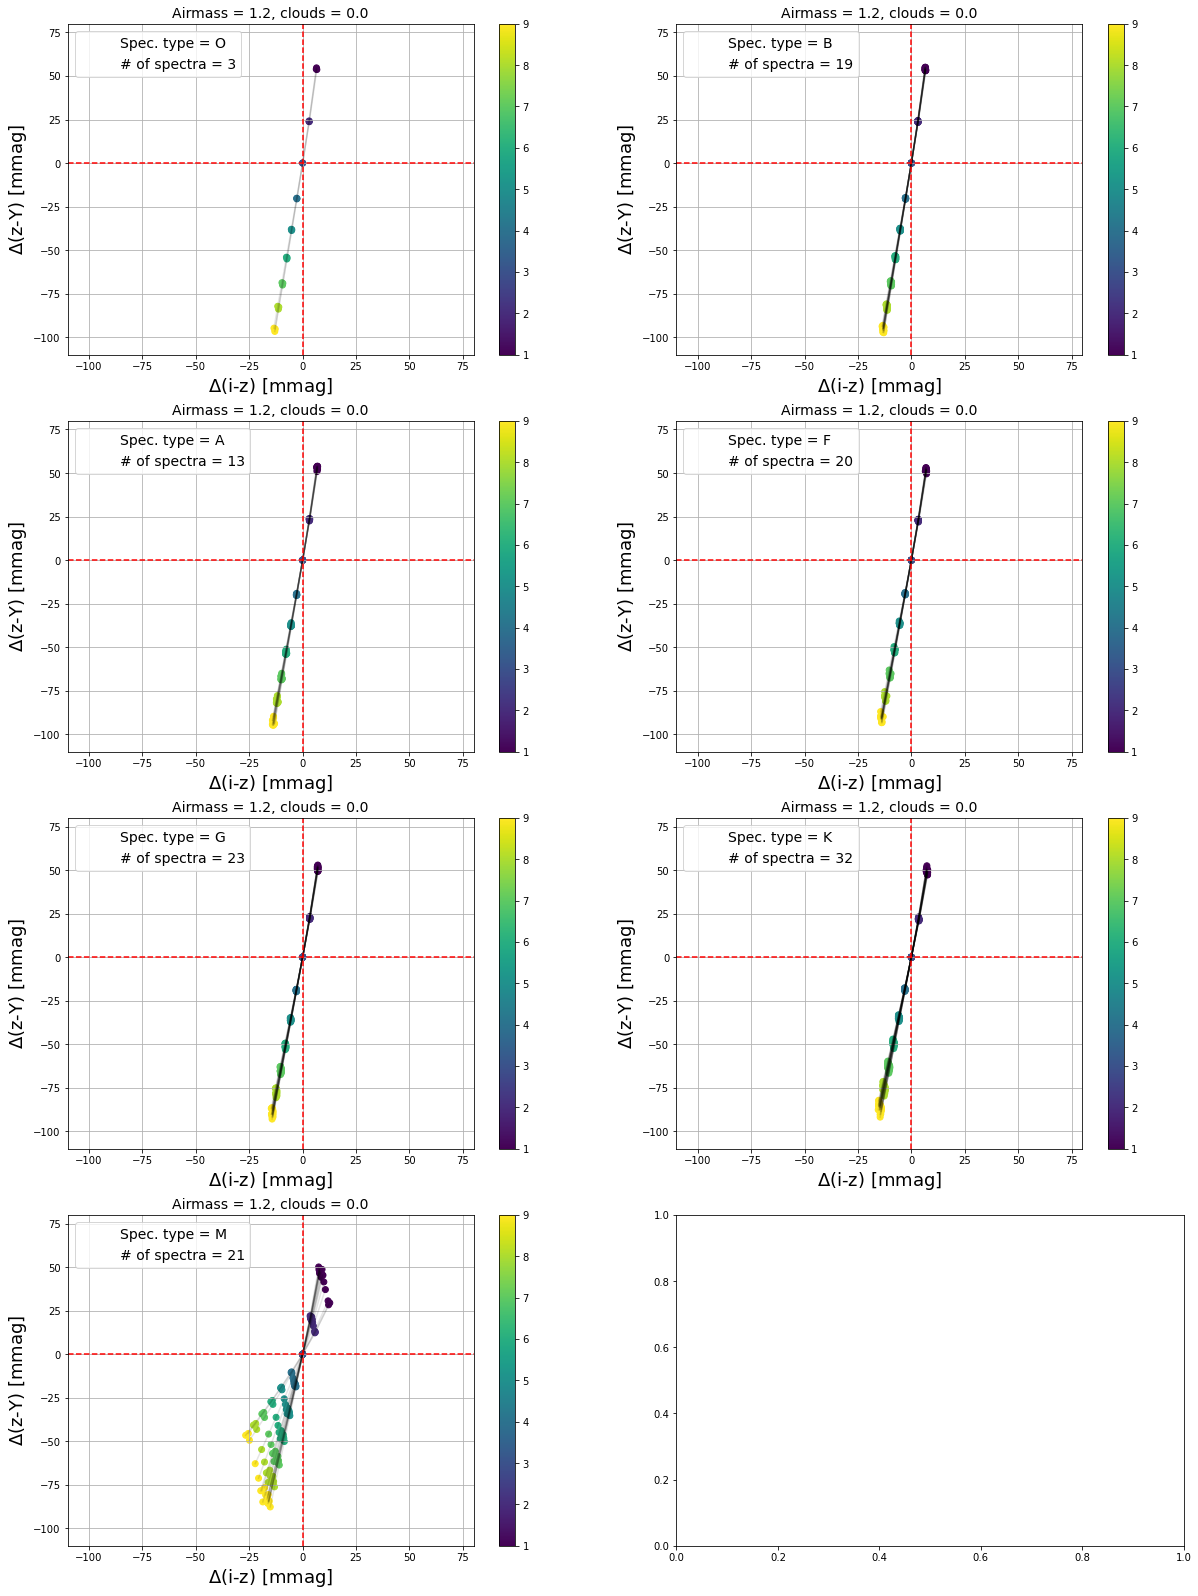

In [101]:
colorx = 'i-z'
colory = 'z-Y'

fig_rows = 4
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,28))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(spectral_types):
            spec_type = spectral_types[i]
            print(spec_type)
            
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(spec_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[spec_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1


Now we evaluate the different colour - colour plots for the example spectral type: 

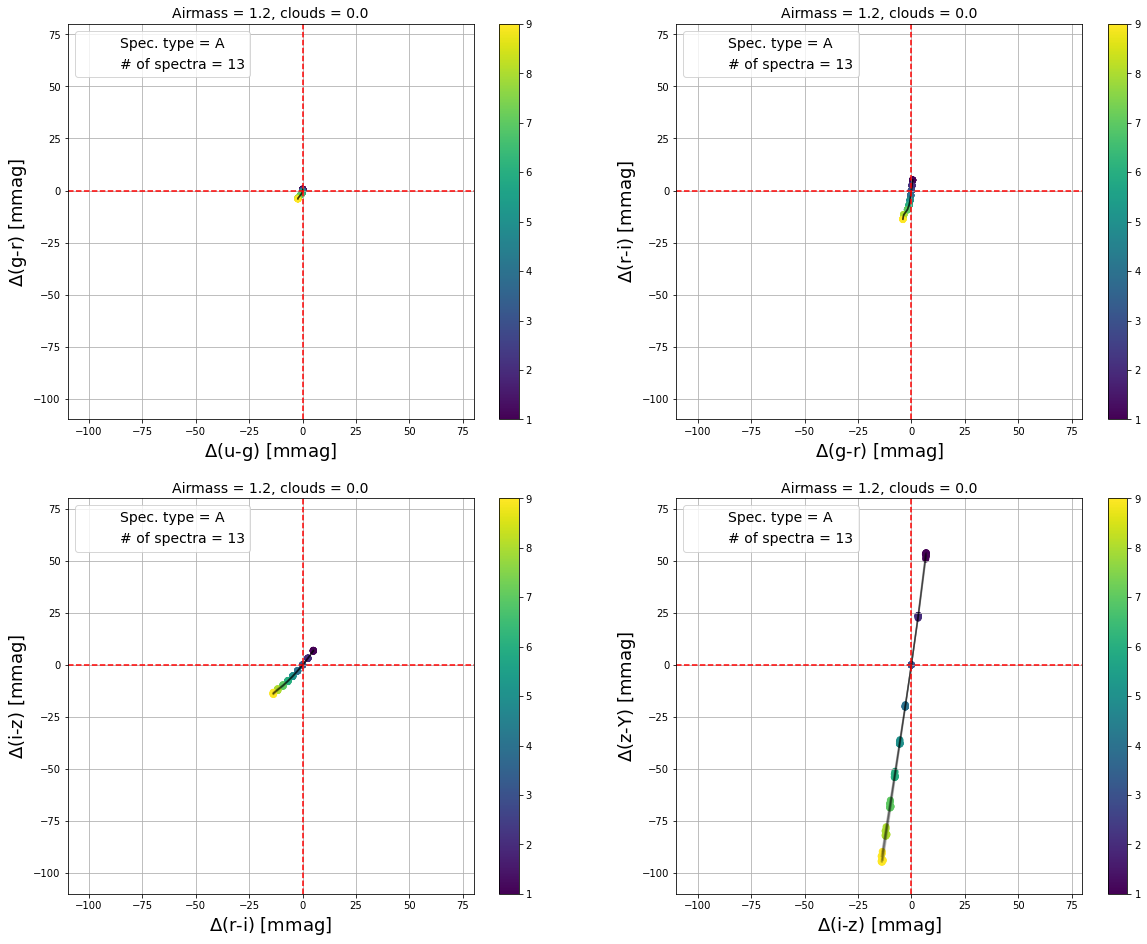

In [102]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for si in colour_dict[test_type]:
                delta1 = (colour_dict[test_type][si][cx.lower()]-colour_dict_ref[test_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[test_type][si][cy.lower()]-colour_dict_ref[test_type][si][cy.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            #axs[row,col].set_xlim(-0.012,0.021)
            #axs[row,col].set_ylim(-0.065,0.126)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(test_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[test_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1

We also evaluate the dependency of the colours with the atmospheric parameters for each spectral type: 

In [103]:
type_markers = {'O':'s','B':'x','A':'o','F':'v','G':'^','K':'P','M':'*'}

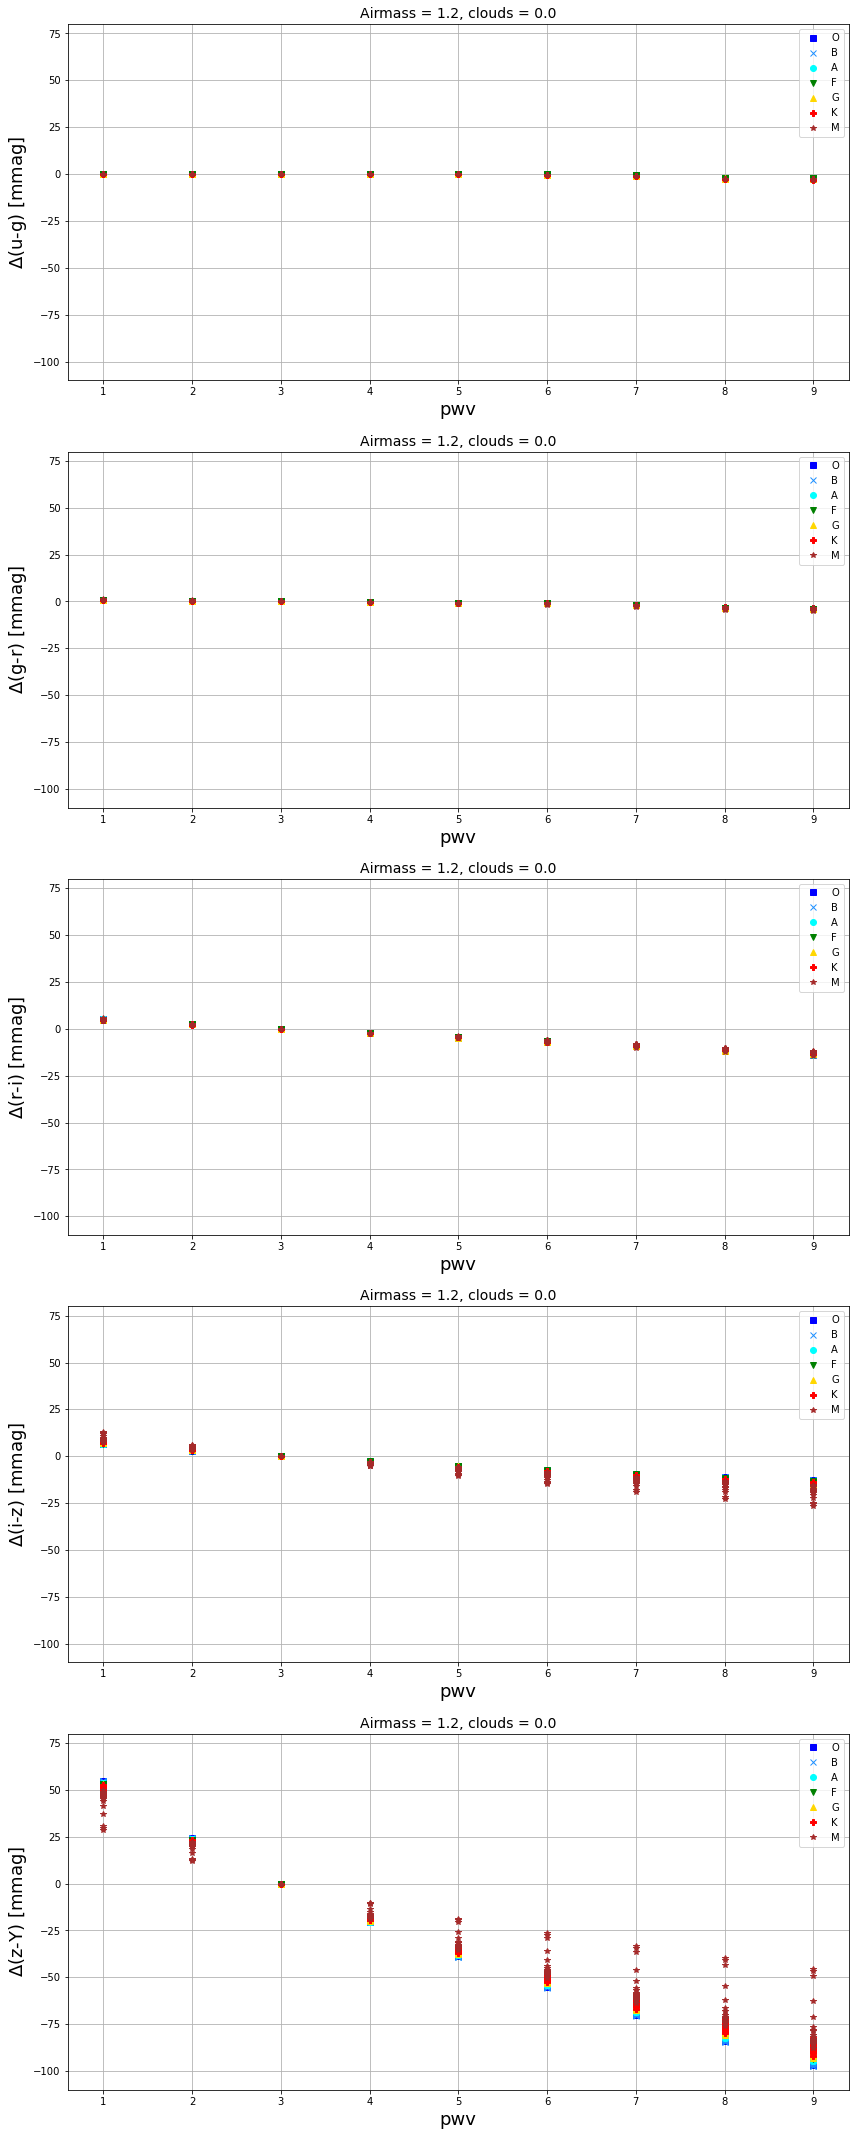

In [104]:
fig_rows = len(filters)-1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(14,38))
for row in range(fig_rows):
    c = '{0}-{1}'.format(filters[row],filters[row+1])
    for spec_type in spectral_types:
        for si in mag_dict[spec_type]:
            delta_c_ = (colour_dict[spec_type][si][c.lower()]-colour_dict_ref[spec_type][si][c.lower()])*1000.
            axs[row].plot(atm_vals,delta_c_,ls='',marker=type_markers[spec_type],color=type_colors[spec_type])
        axs[row].plot([],[],ls='',marker=type_markers[spec_type],color=type_colors[spec_type],label = spec_type)
    axs[row].set_ylim(rangey)
    axs[row].grid()
    axs[row].set_xlabel(variable_param,fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+c+') [mmag]',fontsize=18)
    axs[row].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
    axs[row].legend()
plt.savefig(os.path.join(outdir_plots,'delta_colours_vs_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))
    

Let's have a look now at the colour-colour plots for all spectral types together 

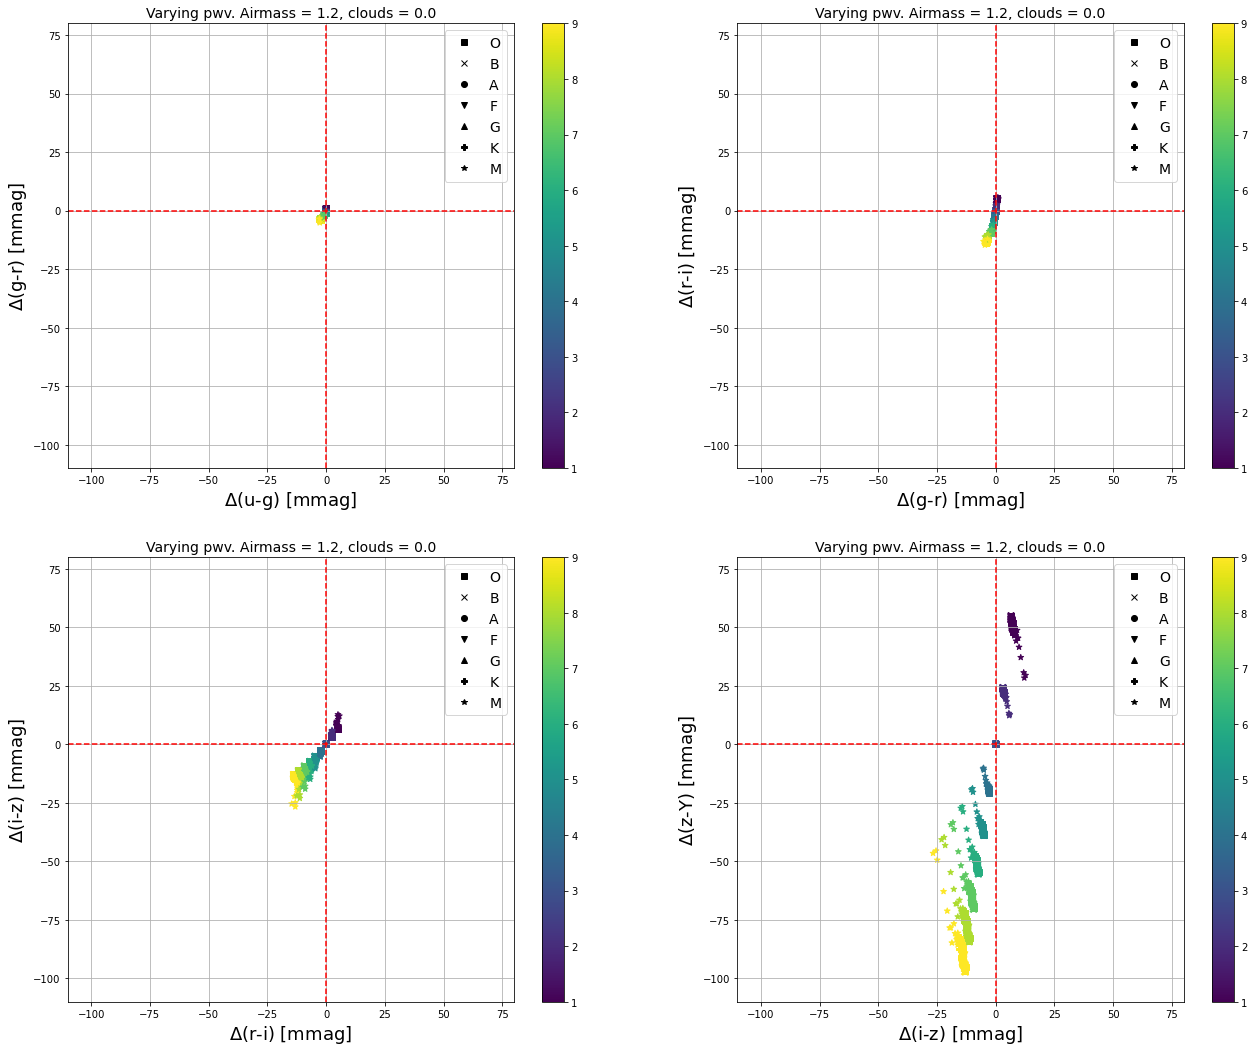

In [105]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    if sed_==0:
                        im = axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    else:
                        axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    #axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c='k',ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

An alternative way of plotting this: 

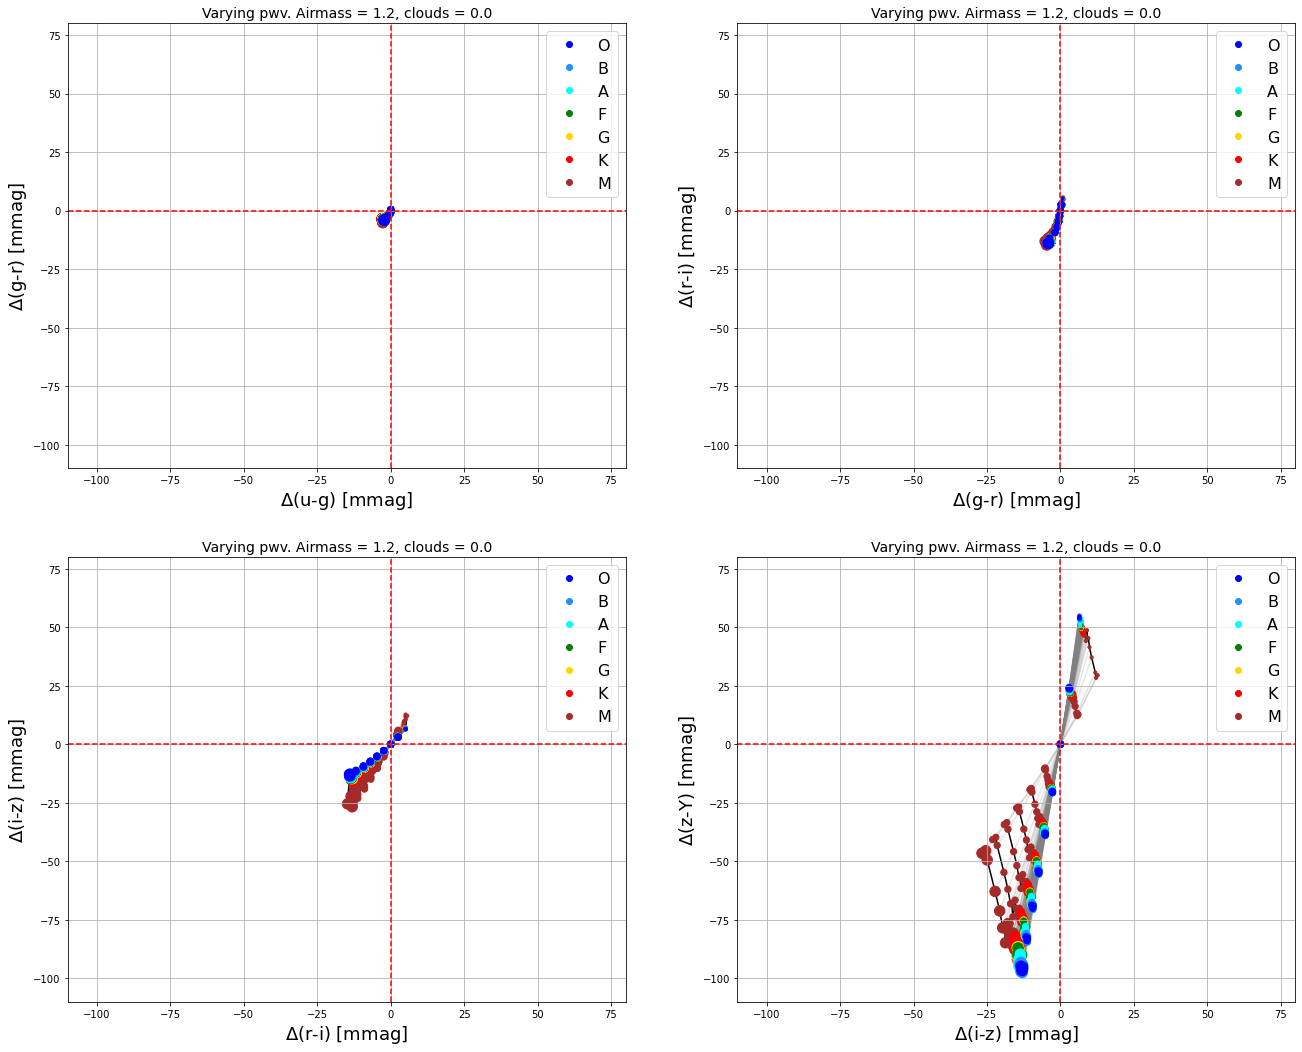

In [151]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    iso_vals1.append(delta1)
                    iso_vals2.append(delta2)
                    
                    axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            for spec_type in spectral_types:
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
                
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            i += 1
            
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}_v2.png'.format(variable_param,am0,cloud0)))

Plot and save them individually: 

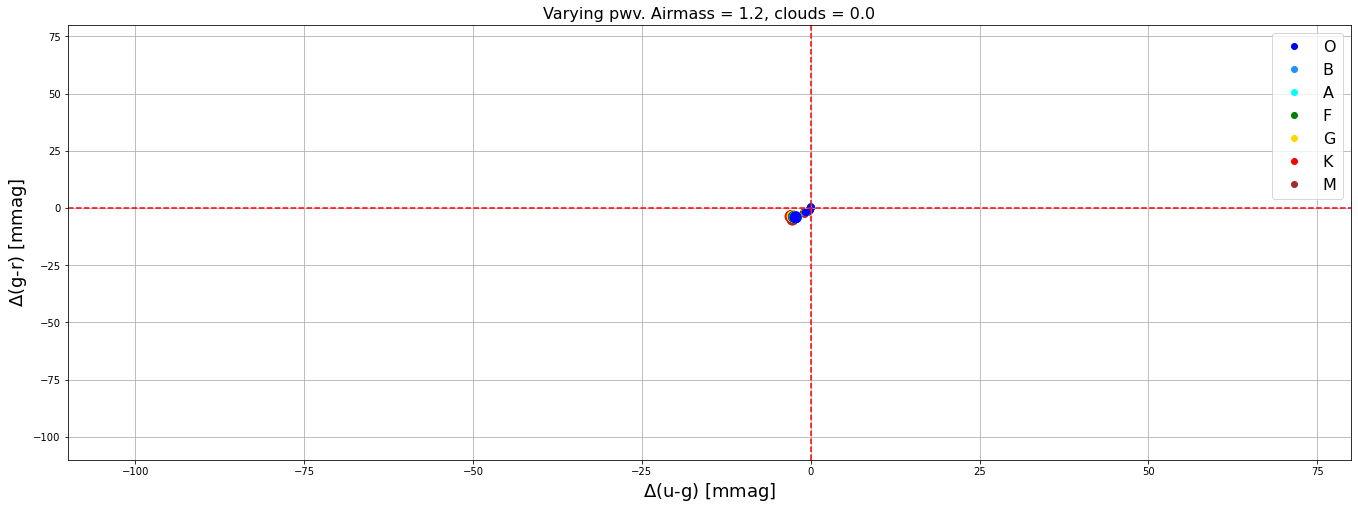

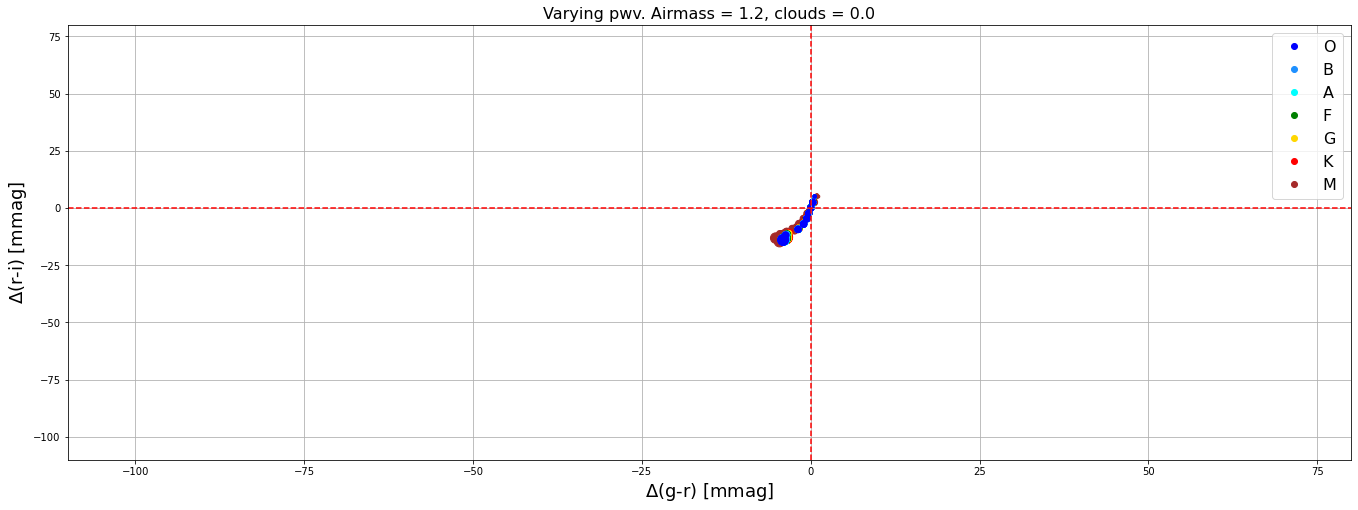

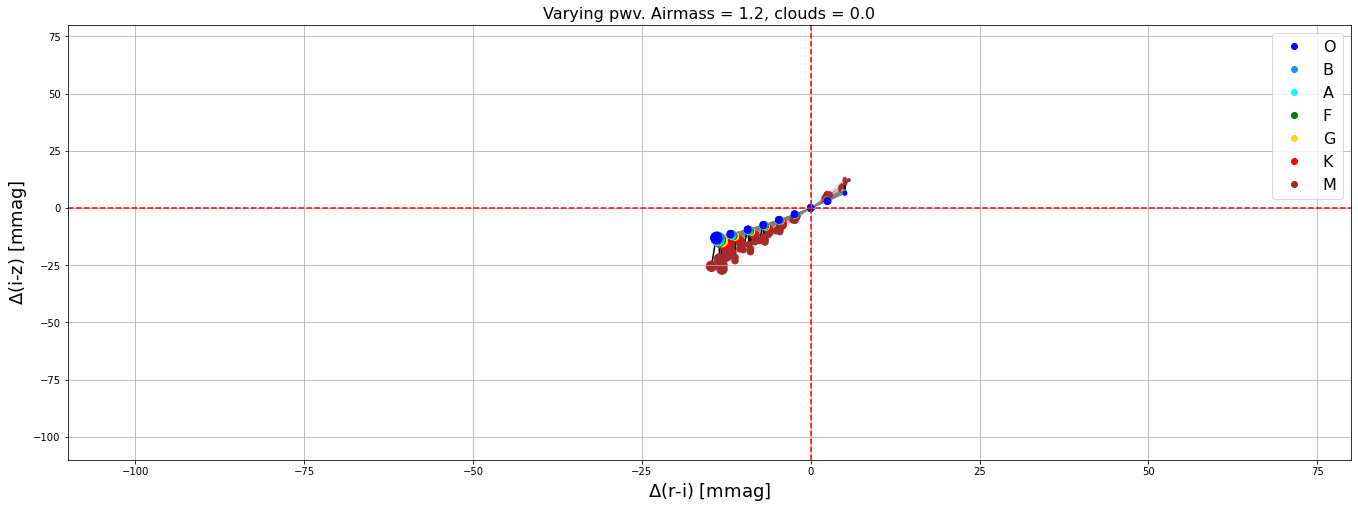

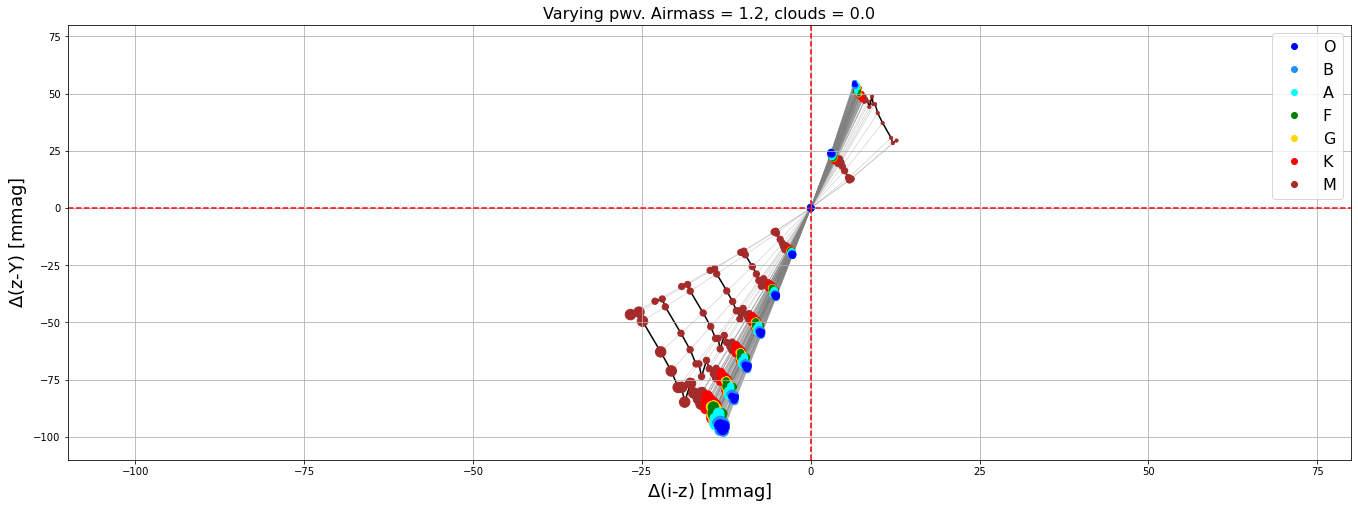

In [150]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(23,8))
    if i<len(filters)-2:
        cx = '{0}-{1}'.format(filters[i],filters[i+1])
        cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangex)
        #axs.set_xlim(-50,30)
        axs.set_ylim(rangey)
        #axs.set_ylim(-140,90)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=16)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0,cx,cy)))

Now we look at the same information but restricted to the most extreme atmospheric parameter values: 

u
g
r
i
z
Y
photlam


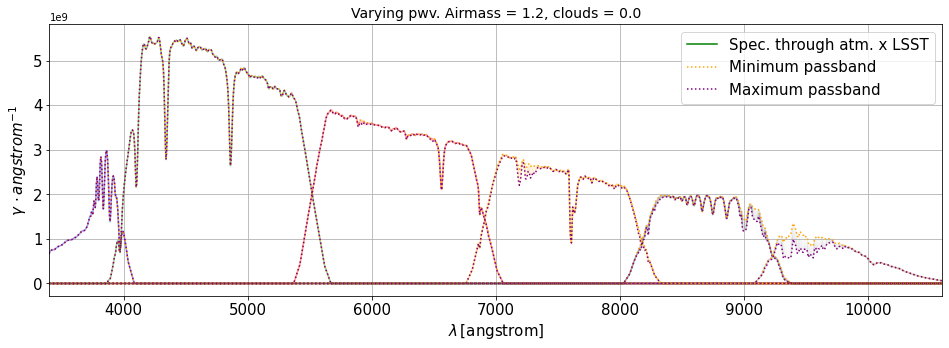

In [108]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
    ax.plot(obstotal_dict[filter][min_ind_].binwave,obstotal_dict[filter][min_ind_].binflux*Seff*exptime,ls=':',color='orange')
    ax.plot(obstotal_dict[filter][max_ind_].binwave,obstotal_dict[filter][max_ind_].binflux*Seff*exptime,ls=':',color='purple')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.plot([],[],ls=':',color='orange',label='Minimum passband')
plt.plot([],[],ls=':',color='purple',label='Maximum passband')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_min_max_total_passband_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))
print(spec.fluxunits)

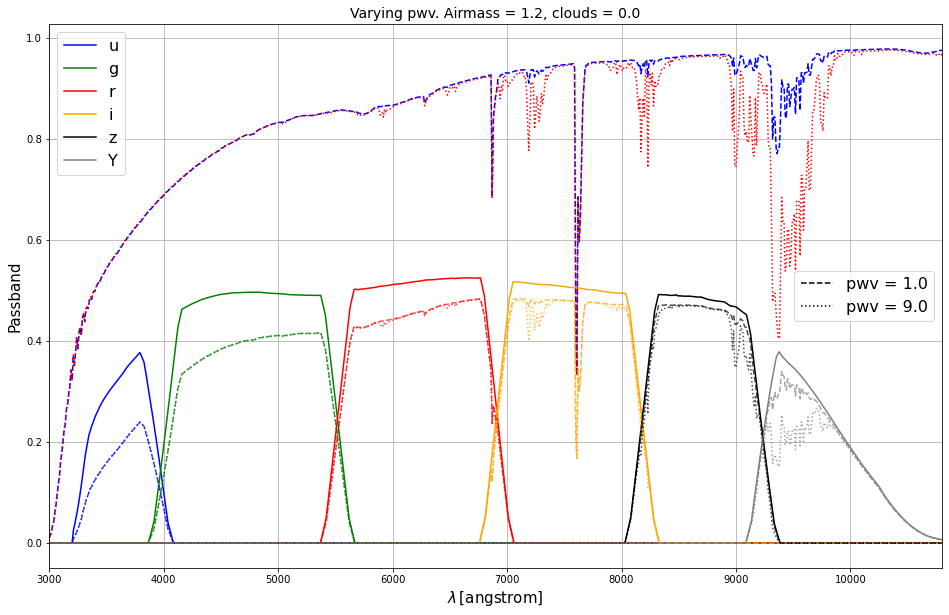

In [109]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
legend_lines1 = []
for index,bp in enumerate(lsst_bp):
    line_, = ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])
    legend_lines1.append(line_)

ax.plot(atm_transp[min_ind_].wave,atm_transp[min_ind_].throughput,ls='--',alpha=1.0,color='b')
ax.plot(atm_transp[max_ind_].wave,atm_transp[max_ind_].throughput,ls=':',alpha=1.0,color='r')

for index,bpname in enumerate(filters):
    ax.plot(total_passband[bpname][min_ind_].wave,total_passband[bpname][min_ind_].throughput,ls='--',color=filter_colors[index],alpha=0.7)
    ax.plot(total_passband[bpname][max_ind_].wave,total_passband[bpname][max_ind_].throughput,ls=':',color=filter_colors[index],alpha=0.7)        
line1, = plt.plot([],[],ls='--',color='k',label='{0} = {1}'.format(variable_param,min_val_))
line2, = plt.plot([],[],ls=':',color='k',label='{0} = {1}'.format(variable_param,max_val_))
legend_lines2 = [line1,line2]
plt.xlim(3000.,10800.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Passband',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
legend1 = plt.legend(handles=legend_lines1,fontsize=16,loc="upper left")
plt.gca().add_artist(legend1)
plt.legend(handles=legend_lines2,fontsize=16,loc="center right")
plt.savefig(os.path.join(outdir_plots,'total_passbands_min_max_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

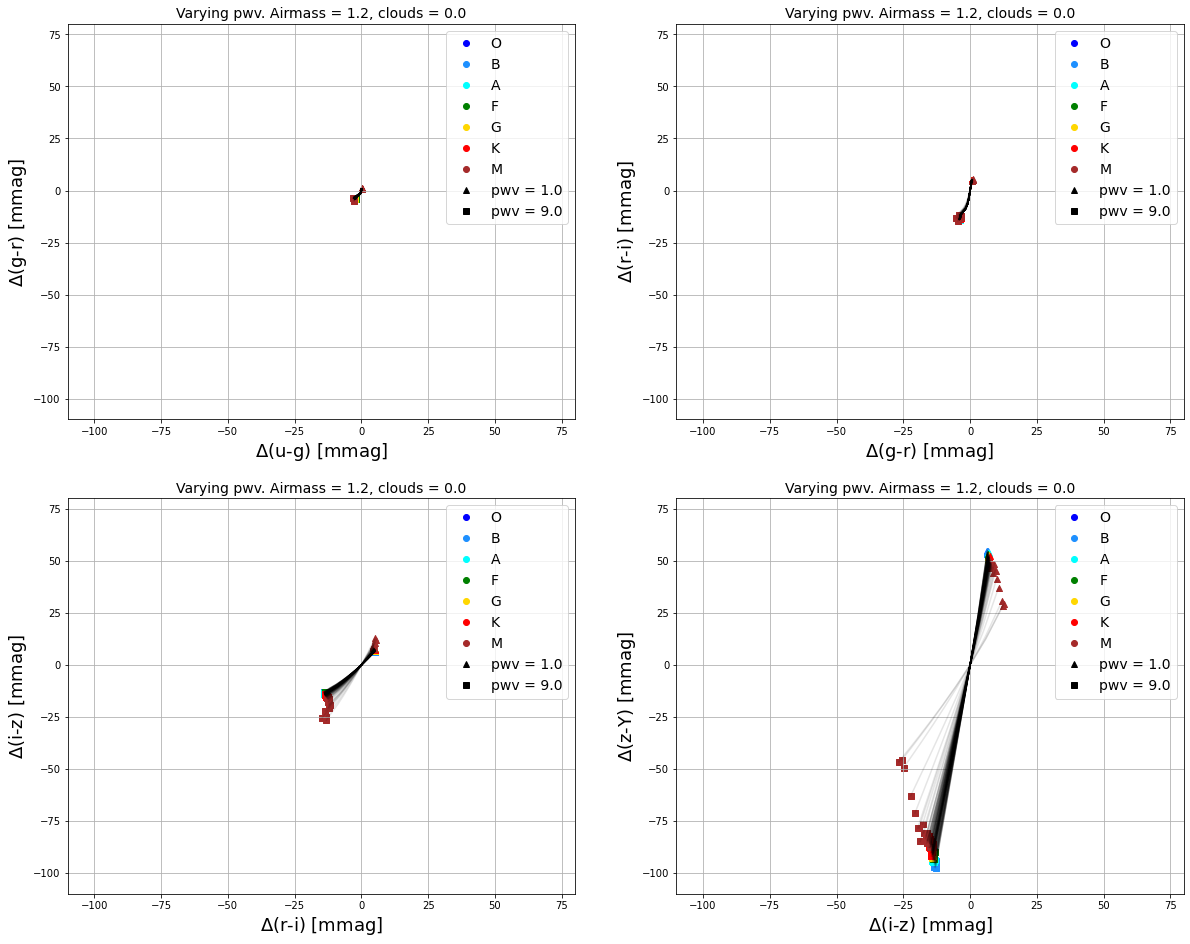

In [110]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_min = (colour_dict[spec_type][si][cx.lower()][min_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_min = (colour_dict[spec_type][si][cy.lower()][min_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_min,delta2_min,c=type_colors[spec_type],marker='^')
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker='s')
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            axs[row,col].plot([],[],ls='',marker='^',color='k',label='{0} = {1}'.format(variable_param,atm_vals[min_ind_]))
            axs[row,col].plot([],[],ls='',marker='s',color='k',label='{0} = {1}'.format(variable_param,atm_vals[max_ind_]))
            #axs[row,col].axhline(y=0.,ls='--',color='r')
            #axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
    
            i += 1

plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_min_max_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

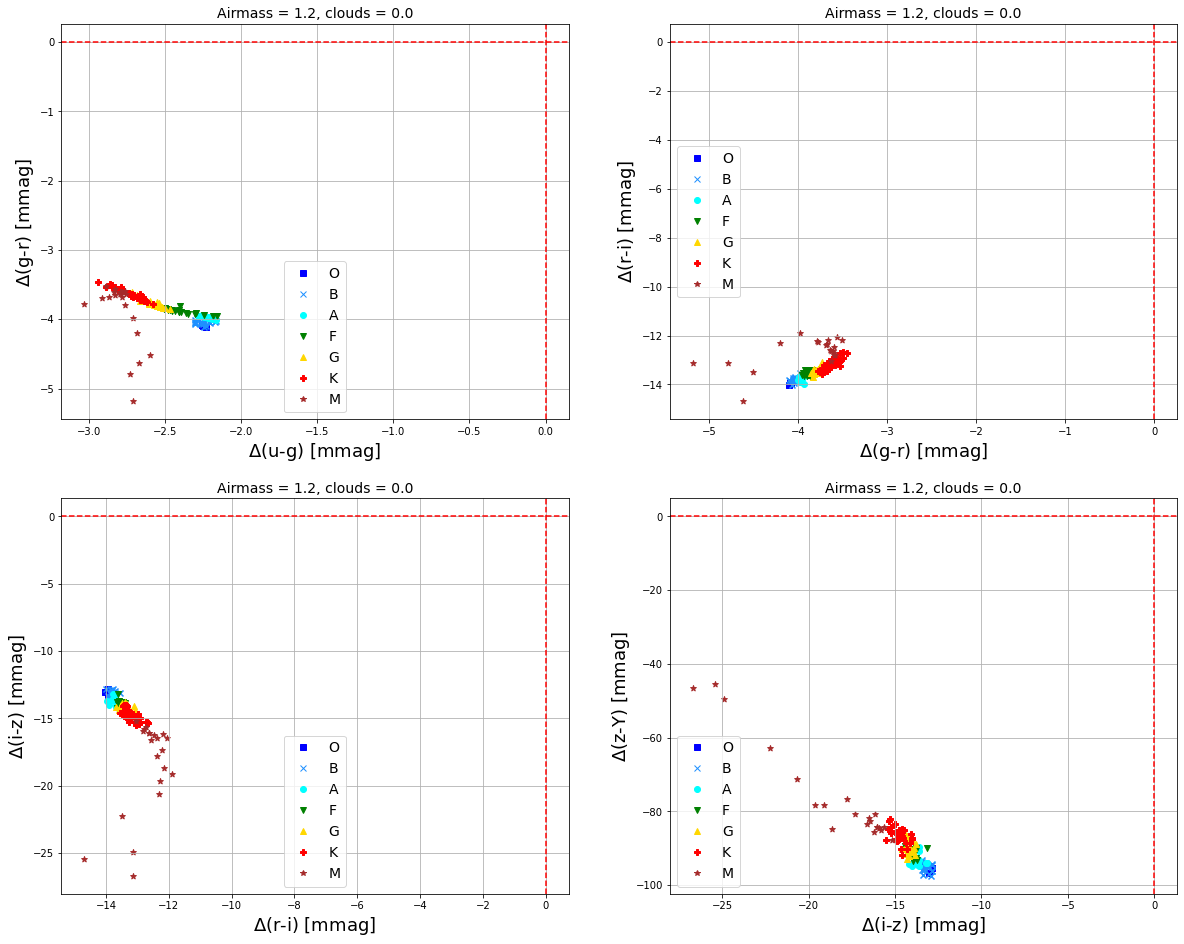

In [111]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

We exclude the M type spectra for more clarity: 

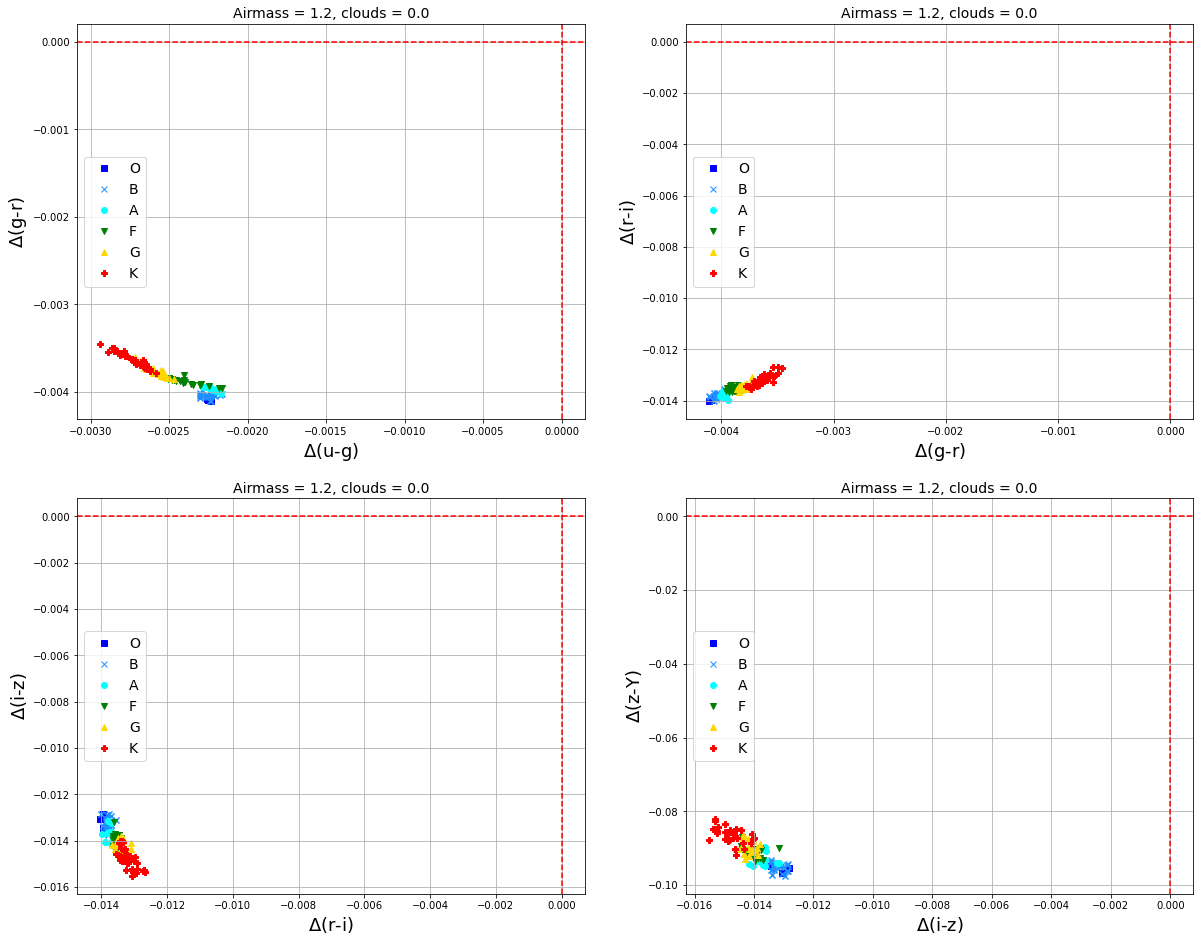

In [112]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types[:-1]:
                for si in colour_dict[spec_type]:
                    delta1_max = colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()]
                    delta2_max = colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()]
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+')',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+')',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

# Make 3D colour plot 

To see an interactive version of the following plot, see notebook "03_spectrum_ThroughAtmLSST_3Dcolor_plot.ipynb" 

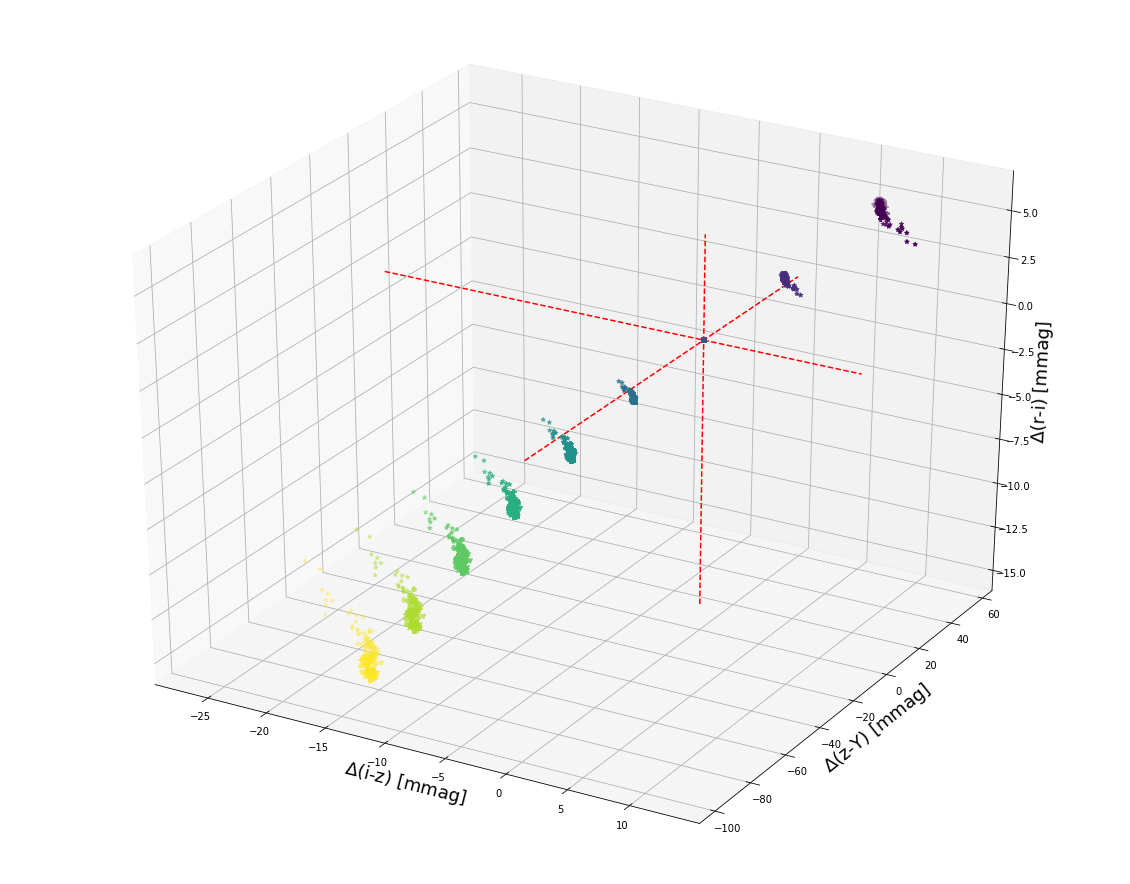

In [113]:
colorx = 'i-z'
colory = 'z-Y'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


# Calculate colour evolution for SNe Ia spectra 

We use the SNe Ia spectra from https://github.com/rhiannonlynne/photometry_sample/tree/main/sn 

In [114]:
sne_path = 'data/SNIa_spectra/'
sn1_data = np.loadtxt(os.path.join(sne_path,'sn1a_10.0.dat'))
sn2_data = np.loadtxt(os.path.join(sne_path,'sn1a_15.0.dat'))
sn3_data = np.loadtxt(os.path.join(sne_path,'sn1a_20.0.dat'))

The wavelengths are in nm and the fluxes in erg/s/cm2/nm, so we need to change the units to angstrom and photlam = #photons/s/cm2/angstrom (pysynphot assumes that the input fluxes are in photlam). For this, we need to remember that the conversion between flam (erg/s/cm2/angstrom) and photlam is given by 

$$ photlam = \frac{\lambda}{h \cdot c} flam $$

In [115]:
sn1wave = sn1_data[:,0]*10.
sn2wave = sn2_data[:,0]*10.
sn3wave = sn3_data[:,0]*10.

sn1flux = sn1_data[:,1]*sn1wave/(h_planck*c_light)
sn2flux = sn2_data[:,1]*sn2wave/(h_planck*c_light)
sn3flux = sn3_data[:,1]*sn3wave/(h_planck*c_light)

In [116]:
sn1 = S.ArraySpectrum(sn1wave,sn1flux,name='sn1a_10.0')
sn2 = S.ArraySpectrum(sn2wave,sn2flux,name='sn1a_15.0')
sn3 = S.ArraySpectrum(sn3wave,sn3flux,name='sn1a_20.0')

In [117]:
sn1.waveunits, sn1.fluxunits

(<pysynphot.units.Angstrom at 0x7fc9f1e2e2b0>,
 <pysynphot.units.Photlam at 0x7fc9e739a2e0>)

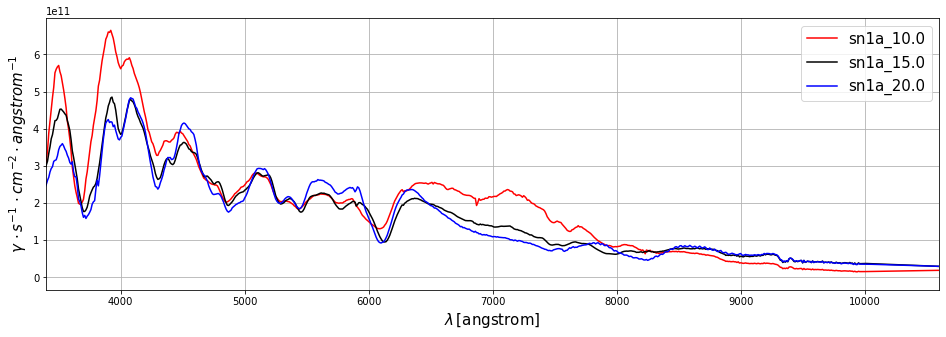

In [118]:
fig=plt.figure(figsize=(16,5))
plt.plot(sn1.wave,sn1.flux,color='r',label=sn1.name)
plt.plot(sn2.wave,sn2.flux,color='k',label=sn2.name)
plt.plot(sn3.wave,sn3.flux,color='b',label=sn3.name)
plt.xlim(WLMIN,WLMAX)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot s^{-1} \, \cdot cm^{-2} \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=15)

Now we pass the SNIa spectra through the total passbands, as with the calibration spectra 

In [119]:
sn_list = [sn1,sn2,sn3]

In [120]:
# SNe Ia through atm x throughput 
sn_obs_dict = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in filters:
        filter_dict_[filter] = []
        for i in range(n_sim):
            obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
            filter_dict_[filter].append(obs_spec)
    sn_obs_dict[si] = filter_dict_ 


((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [121]:
print(len(sn_obs_dict.keys()))
print(len(sn_obs_dict[0].keys()))
print(len(sn_obs_dict[0]['u']))

3
6
9


In [122]:
# SNe Ia only through throughput (as if telescope was in space) 
sn_obs_dict_t = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in lsst_bp:
        obs_spec_t = S.Observation(spec,filter,force='taper')
        filter_dict_[filter.name] = obs_spec_t
    sn_obs_dict_t[si] = filter_dict_ 
    

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in

In [123]:
print(len(sn_obs_dict_t.keys()))
print(len(sn_obs_dict_t[0].keys()))
print(sn_obs_dict_t[0]['u'].flux)

3
6
[ 0.  0.  0. ... nan nan nan]


Text(0.5, 1.0, 'Varying pwv. Airmass = 1.2, clouds = 0.0')

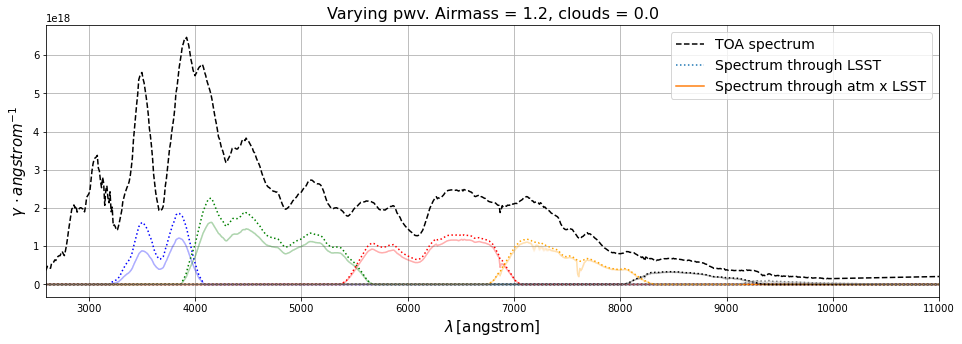

In [124]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We zoom in to see the effect of the different atmospheric transparencies 

Text(0.5, 1.0, 'Varying pwv. Airmass = 1.2, clouds = 0.0')

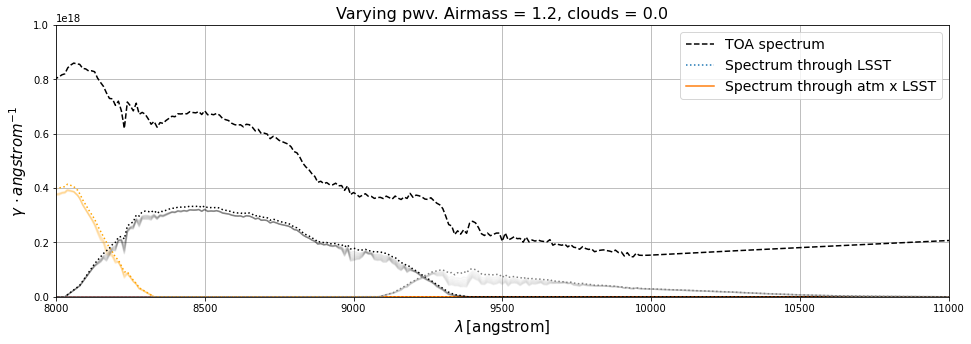

In [125]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.07)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(8000.,11000.)
plt.ylim(0,1e18)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We can now calculate the magnitudes and colours 

In [126]:
# Magnitudes of spectra passing through atm x throughput 
sn_mag_dict = {}
sn_mag_dict_ref = {}
for si,obs_spec_ in enumerate(sn_list):
    mag_dict_ = {}
    mag_dict_ref_ = {}
    for fi,filter in enumerate(filters):
        mag_dict_[filter] = []
        for i in range(n_sim):
            #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
            mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
            mag_dict_[filter].append(mag_ab_)
            
        #mag_dict[sed_] = mag_dict_
        
        mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
        mag_dict_ref_[filter] = mag_ab_
    sn_mag_dict[si] = mag_dict_
    sn_mag_dict_ref[si] = mag_dict_ref_

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.478758025423094
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.478768893864263
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.47878161751223
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. Th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.737135276332054
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.734484864421788
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.753140409524875
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.8548012

-20.727503046020367
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.727536999764116
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.72770362429455
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.72821692879447
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in th

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.525625283612833
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.502647820798668
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.481568786229012
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.4618076

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.097861894995717
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.09521771824929
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.092649803487625
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.08999068

In [127]:
print(len(sn_mag_dict.keys()))
print(len(sn_mag_dict[0].keys()))
print(len(sn_mag_dict[0]['u']))

3
6
9


In [128]:
sn_colour_dict = {}
for sn in sn_mag_dict.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    sn_colour_dict[sn] = c_dict


In [129]:
print(len(sn_mag_dict.keys()))
print(len(sn_colour_dict.keys()))
print(len(sn_colour_dict[0].keys()))
print(len(sn_colour_dict[0]['u-g']))

3
3
5
9


In [130]:
sn_colour_dict_ref = {}
for sn in sn_mag_dict_ref.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict_ref[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict_ref[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    sn_colour_dict_ref[sn] = c_dict
    

In [131]:
print(len(sn_mag_dict_ref.keys()))
print(len(sn_colour_dict_ref.keys()))
print(len(sn_colour_dict_ref[0].keys()))
print(sn_colour_dict_ref[0]['u-g'])

3
3
5
0.34546386375220806


In [132]:
np.save('output_files/sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),sn_colour_dict)
np.save('output_files/sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),sn_colour_dict_ref)

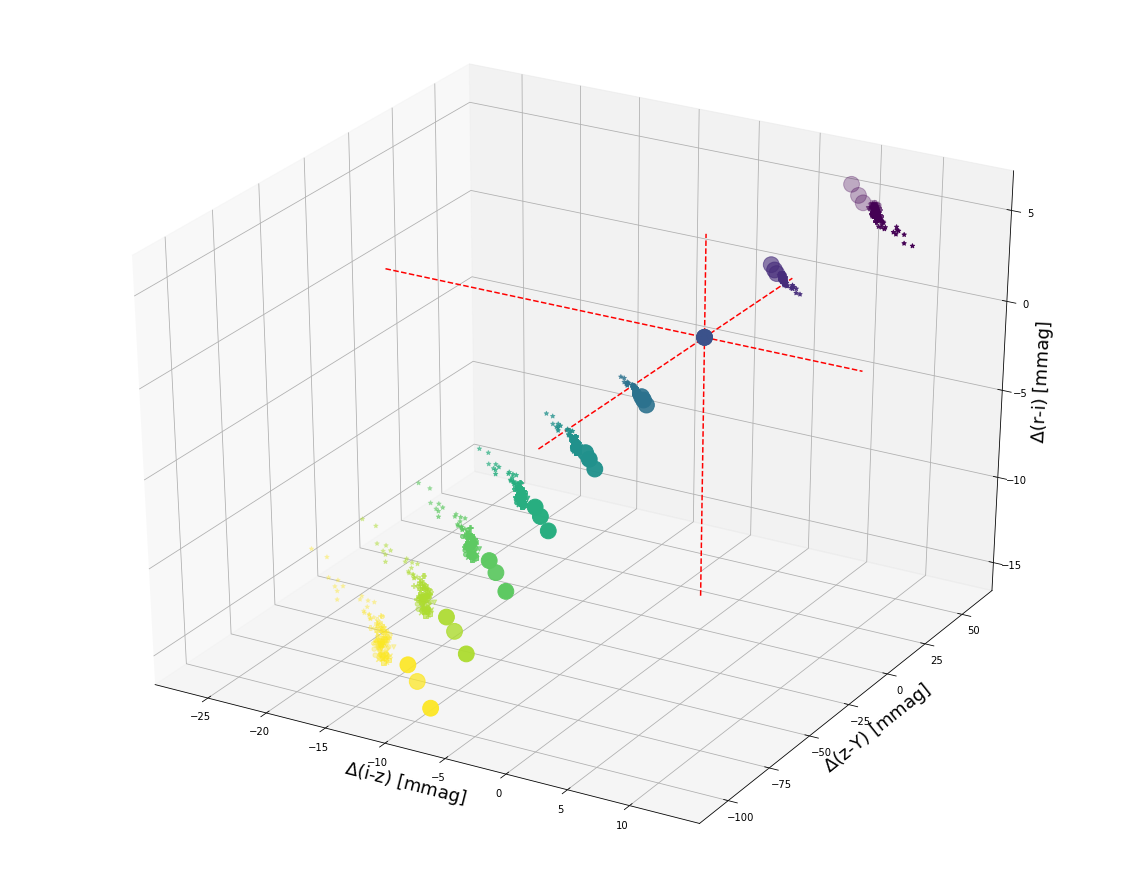

In [133]:
colorx = 'i-z'
colory = 'z-Y'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))
        
for sn in sn_colour_dict.keys():
    delta1_sn = (sn_colour_dict[sn][colorx.lower()]-sn_colour_dict_ref[sn][colorx.lower()])*1000.
    delta2_sn = (sn_colour_dict[sn][colory.lower()]-sn_colour_dict_ref[sn][colory.lower()])*1000.
    delta3_sn = (sn_colour_dict[sn][colorz.lower()]-sn_colour_dict_ref[sn][colorz.lower()])*1000.
    
    ax.scatter(delta1_sn,delta2_sn,delta3_sn,c=atm_vals,marker='o',s=250.0)

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


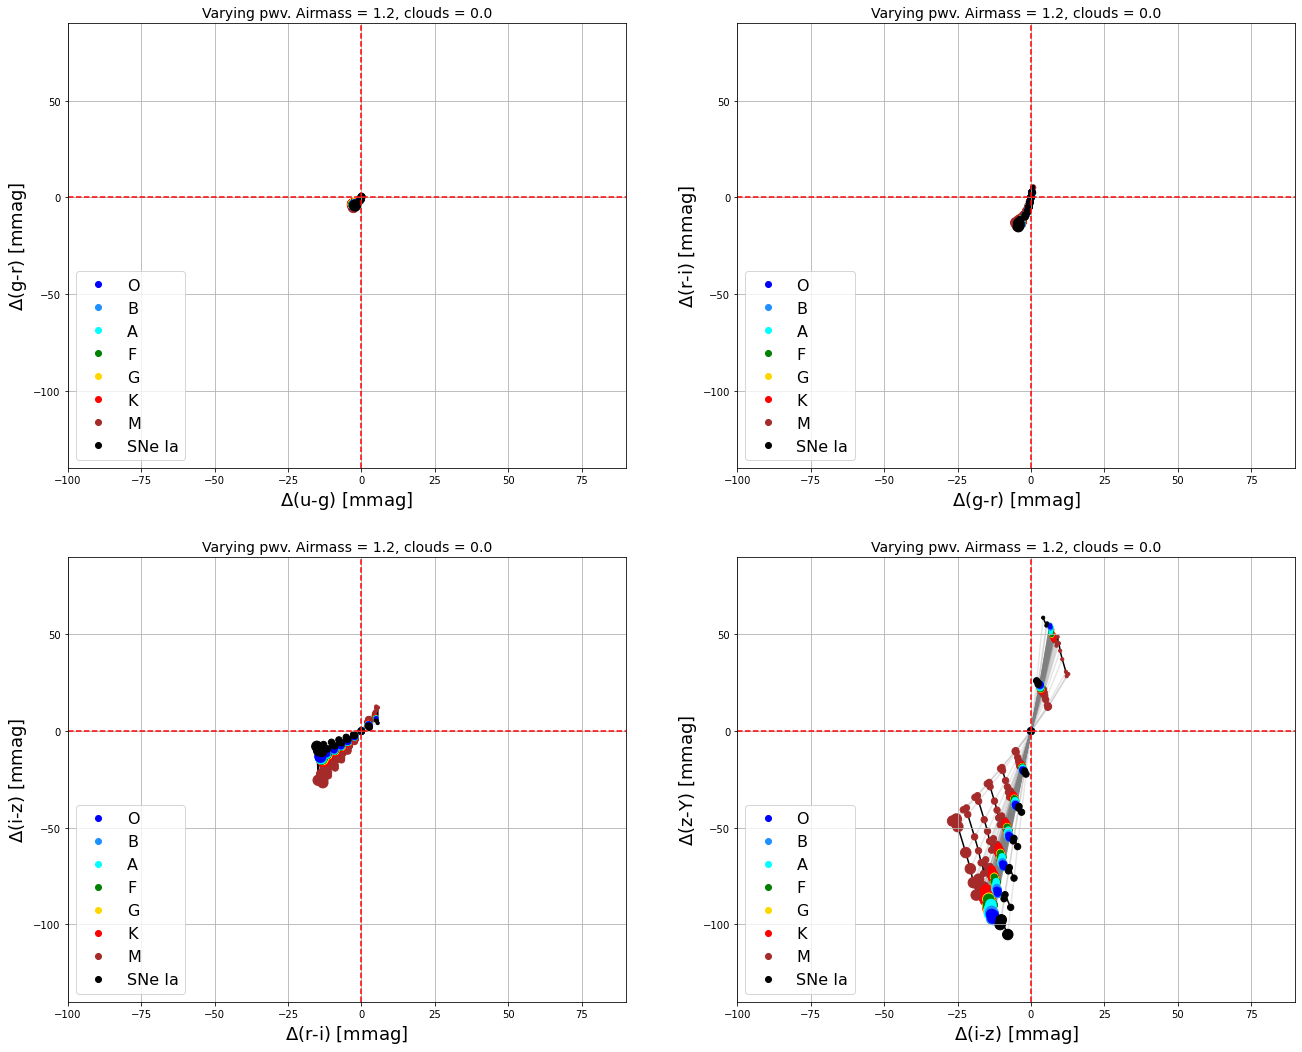

In [149]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    iso_vals1.append(delta1)
                    iso_vals2.append(delta2)
                    
                    axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            for spec_type in spectral_types:
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
                
                
            for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs[row,col].scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs[row,col].plot(delta1_sn,delta2_sn,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            axs[row,col].plot([],[],c='k',ls='',marker='o',label='SNe Ia')
            
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(-100,90)
            axs[row,col].set_ylim(-140,90)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            
            i += 1
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}_v2_sn.png'.format(variable_param,am0,cloud0)))

In [135]:
rangex2 = (-40,25)
rangey2 = (-150,90)

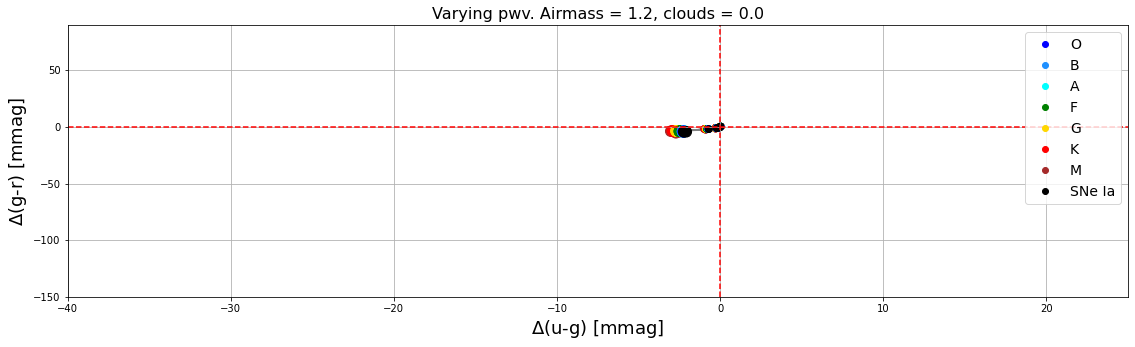

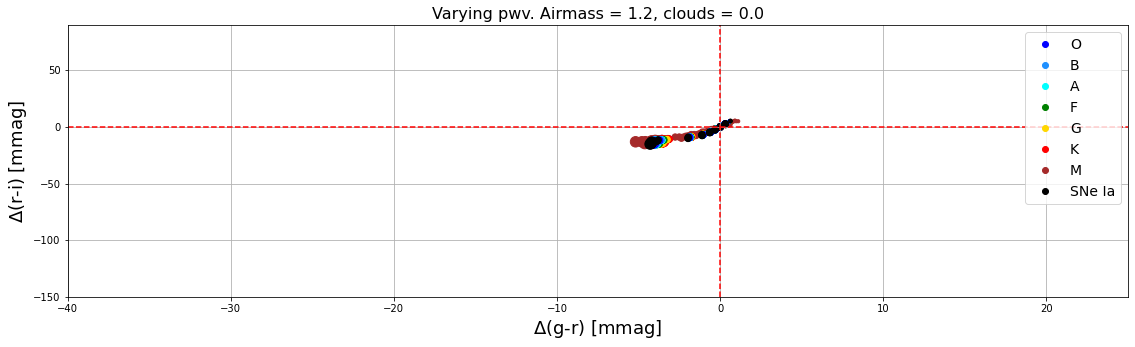

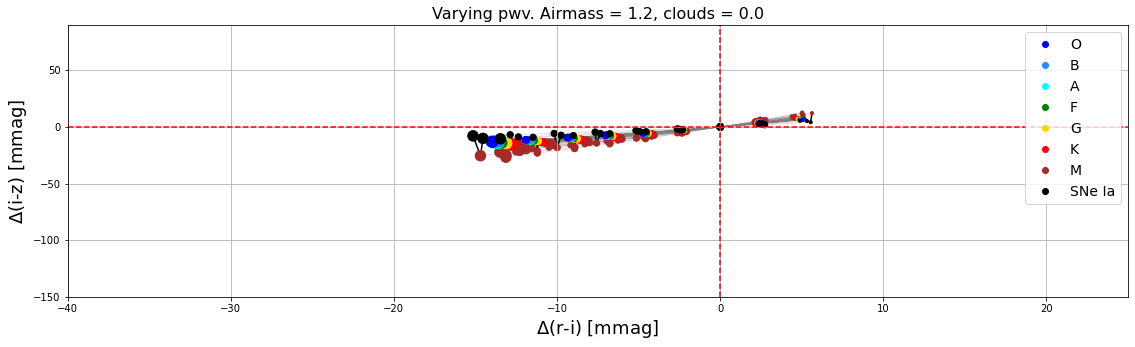

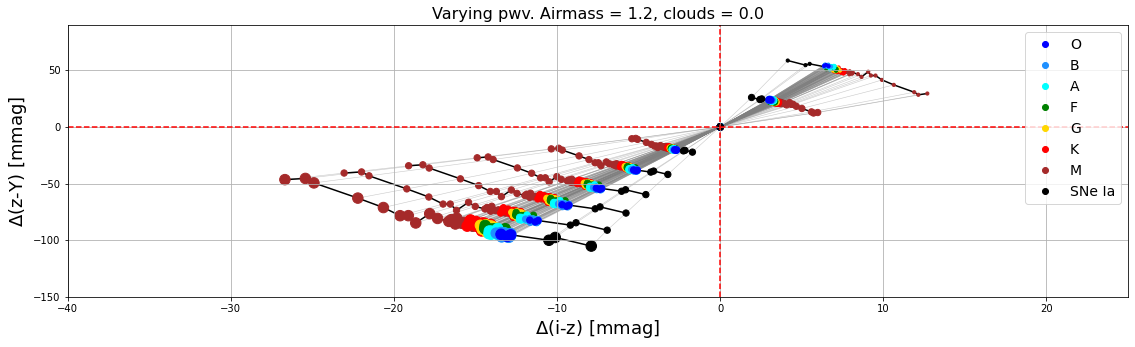

In [148]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(19,5))
    if i<len(filters)-2:
        cx = '{0}-{1}'.format(filters[i],filters[i+1])
        cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangex2)
        axs.set_ylim(rangey2)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn.png'.format(variable_param,am0,cloud0,cx,cy)))

This is just the same but interchanging the axes 

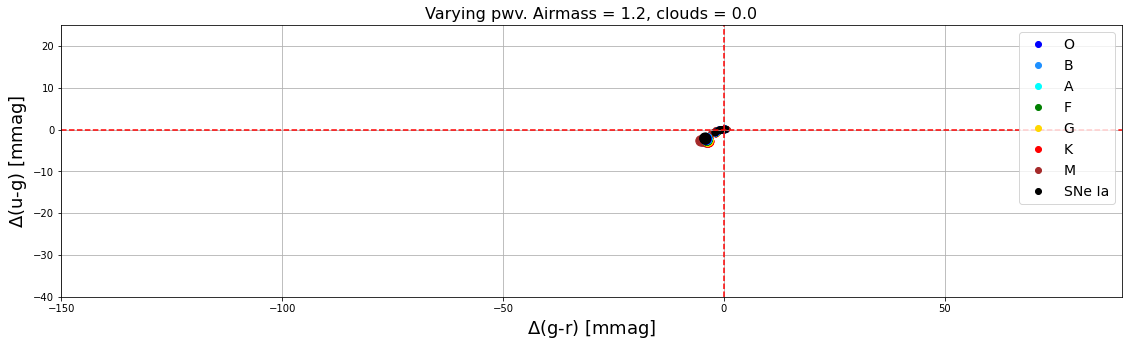

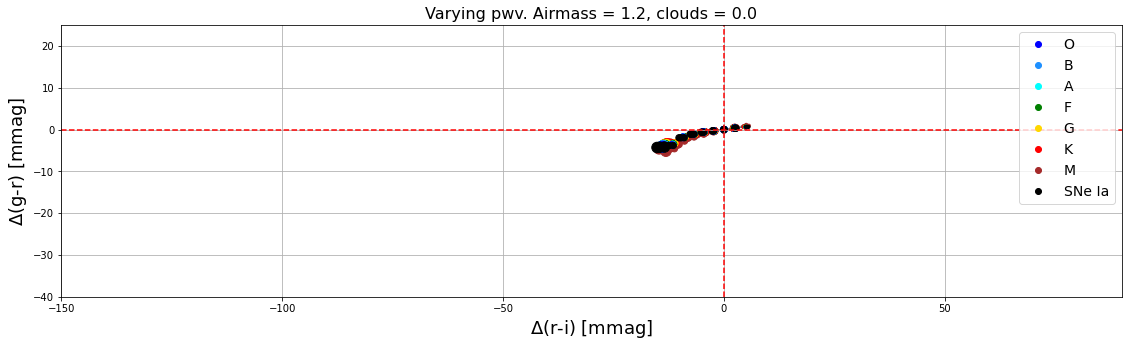

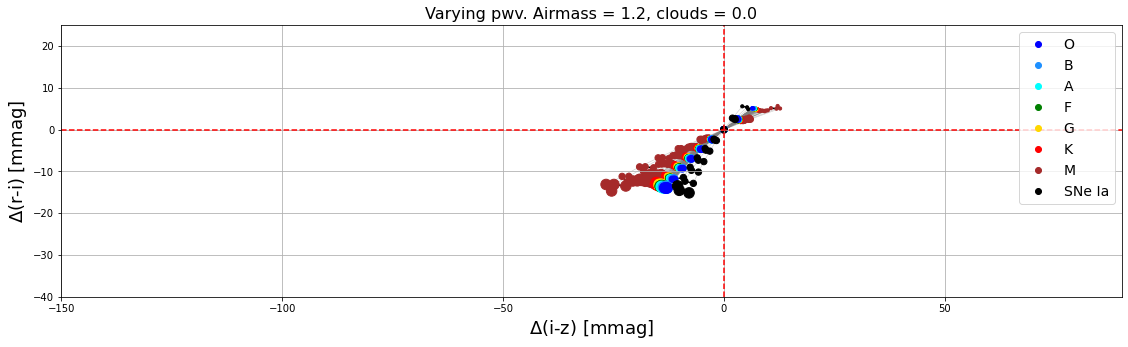

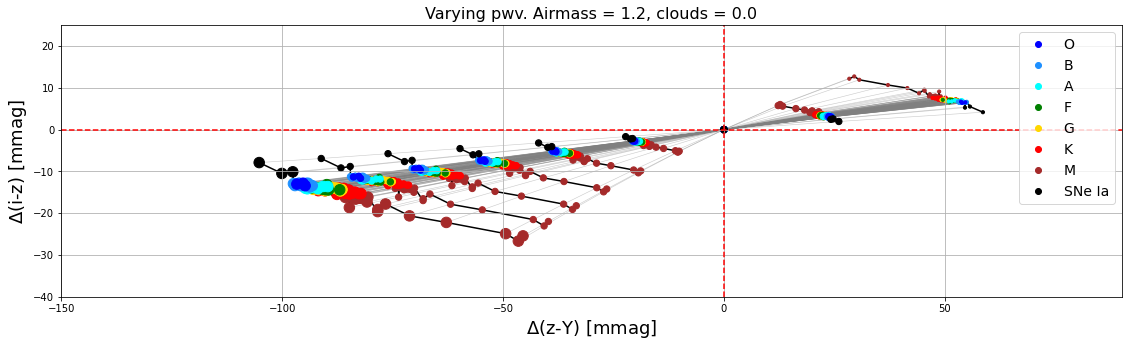

In [147]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(19,5))
    if i<len(filters)-2:
        cy = '{0}-{1}'.format(filters[i],filters[i+1])#################
        cx = '{0}-{1}'.format(filters[i+1],filters[i+2])#################
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangey2)#################
        axs.set_ylim(rangex2)#################
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn.png'.format(variable_param,am0,cloud0,cx,cy)))